In [2]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import cm
import plotly.express as px

# Simulation d'un augmentorium :

---
Introduction : *

L'augmentorium est un dispositif de lutte biologique mis en place dans les cultures touchées par la mouche des fruits.  Il peut être vu comme une tente où les fruits infectés sont entreposés. Le ravageur va alors continuer son cycle de reproduction dans l'augmentorium et les auxiliaires (parasites) vont pouvoir s'y reproduire.  
Une grille permet, via une taille de maille optimale, d'empêcher le ravageur de ressortir de l'augmentorium mais de laisser librement les auxiliaires (plus petits) sortir.
 Cette méthode permet d'augmenter le taux d'auxiliaire par rapport au ravageur, son efficacité à été montré sur des cultures.

<div>
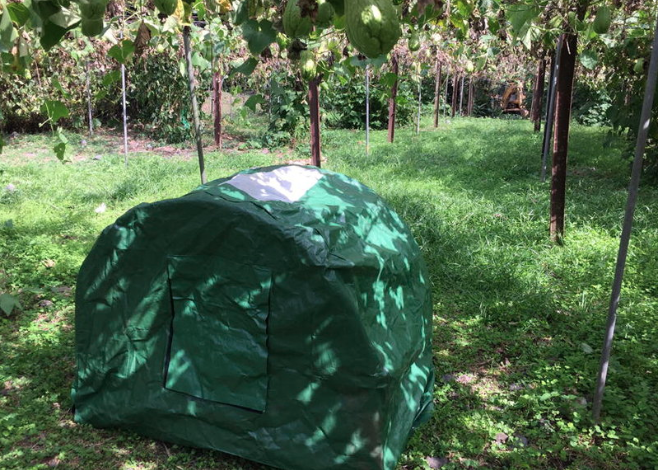
</div>

---

## 1) **Etude d'une population répartie en deux structures spatiales avec migration:** *

*Cette analyse s'appuie sur celle effectuée par [R.Arditi et al.](https://doi.org/10.1016/j.tpb.2015.10.001) en 2015 et a été retravaillée pour coller au modèle de l'augmentorium.*

On s'intéresse à une culture avec des ravageurs et où on va confiner les fruits attaqués dans une structure (une benne par exemple). On met alors en place seulement une mesure prophylactique de débarassage des fruits pourris.  

On part d'un modèle tel que :
$$ 
\left\{\begin{array}{1}
\dot x = r_xx\left(1-\frac{x}{K_x}\right)+\beta(y-x)\\
\dot y = r_yy\left(1-\frac{y}{K_y}\right)+\beta(x-y)
\end{array}\right.
$$

avec $ \dot x $ la population de ravageurs dans la culture et $ \dot y $ celle dans un espace scindé de la culture.  
$ \beta $ est le taux de migration entre la structure et la culture, la mixité peut aller de nulle à parfaite ($\beta \in [0, +\infty[$).  
$r_x$ et $r_y$ sont respectivement le taux de croissance dans la structure 1 et 2.  
$K_x$ et $K_y$ sont la capacité de charge de la structure 1 et 2.

Ce modèle décrit une situation ou une barrière est mise en deux espaces et où la migration se fait dans les deux sens. Les populations suivent dans chaque espace une croissance logistique.

**Hypothèses propres à la situation d'augmentorium :**

On a un taux de croissance plus fort dans l'augmentorium que dans la culture car regrouper les fruits favorise la croissance des ravageurs et les débarasser de la culture a tendance à faire baisser le taux de croissance des ravageurs dans la culture. On a donc $r_x<r_y$. 

Maintenant, en fonction de la culture qu'on va considérer on peut avoir $K_x>K_y$ et inversement. En effet, si la culture est remontante ie qu'elle produit tout au long de l'année, les apports de fruits dans l'augmentorium ne seront jamais excessifs par rapport au nombre de fruits à l'extérieur, impliquant une capacité maximale plus forte pour la culture ($K_x>K_y$). Par contre si la culture est non-remontante on aura énormément de fruits dans la structure sur une courte période impliquant une possible capacité maximale plus forte pour la structure ($K_x<K_y$).


---

### A) Plan de phase:

$$ 
\left\{\begin{array}{1}
\dot x = 0 \Leftrightarrow  y^*=r_xx^*\left(\frac{1}{r_x}-\frac{1}{\beta}+\frac{x^*}{\beta K_x}\right)\\
\dot y =0 \Leftrightarrow  x^*=r_yy^*\left(\frac{1}{r_y}-\frac{1}{\beta}+\frac{y^*}{\beta K_y}\right)
\end{array}\right.
$$

L'équilibre $ (0,0) $ apparaît alors trivialement. Pour calculer $(x^*,y^*)$ on va injecter $x^*$ dans $y^*$. Ceci donne après développement et factorisation un polynôme du quatrième degré :

$$ 
y\left(r_xr_y\left[\frac{1}{\beta}\left(\frac{1}{\beta}-\frac{1}{r_x}-\frac{1}{r_y}\right)+\frac{1}{r_xr_y}\right]-1\right)+
\frac{y^2r_xr_y}{\beta}\left[\frac{1}{K_y}\left(\frac{1}{r_x}-\frac{1}{\beta}\right)+\frac{1}{K_x}\left(\frac{1}{r_y}-\frac{2}{\beta}+\frac{r_y}{\beta^2}\right)\right]+\\
\frac{2y^3r_xr_y}{\beta^2 K_xK_y}\left(1-\frac{r_y}{\beta}\right)+
\frac{y^4r_xr_y^2}{\beta^3K_y^2K_x} = 0
$$

Qu'on va résoudre grâce à numpy pour avoir les coordonées de l'équilibre. On ajoute le champ de vecteur également.  
*Rappel : Les croisements entre isoclines donnent les équilibres.*

---

In [1]:
#Définition du modèle et des paramètres :
def aug(etat,t,param):
    rx,ry,Kx,Ky,b=param
    x,y=etat
    s=[rx*x*(1-x/Kx)-b*(x-y),ry*y*(1-y/Ky)+b*(x-y)]
    return s 

# Temps d'intégration
ti = np.arange(0,10,0.01)

# Etats initiaux
x0=2
y0=0
e0=[x0,y0]

# Paramètres:
rx=0.5 #taux de croissance dans structure 1
ry=1 #taux de croissance dans structure 2
Kx=2
Ky=1
b=1

param_aug=np.array([rx,ry,Kx,Ky,b])

# Simulation:
s=odeint(aug,e0,ti,args=(param_aug,))

#On utilise numpy pour résoudre le polynôme, il faut donc défnir un monome x, un polynôme p et prendre ses solutions.
#Monome y
y=np.polynomial.Polynomial([0,1])

#Polynome :
pol = y*(rx*ry*((1/b)*((1/b)-(1/rx)-(1/ry))+1/(rx*ry))-1)+(y**2)*((rx*ry)/b)*((1/Ky)*((1/rx)-(1/b))+(1/Kx)*((1/ry)-(2/b)+(ry/(b**2))))+2*(y**3)*((rx*ry)/((b**2)*Kx*Ky))*(1-(ry/b))+(y**4)*((rx*(ry**2))/((b**3)*(Ky**2)*Kx))

#Solution qu'on obtient avec un masque booléen:
sol = pol.roots()[(np.isreal(pol.roots())) 
            *(pol.roots() > 0)]
yeq=sol[0].real

#On déduit x via sa définition par le système:
xeq=(ry*yeq*((1/ry)-(1/b)+(yeq/(b*Ky)))).real


#Affichage du nouveau graphe avec le point d'intersection:
#Plan de phase:
fig,ax=plt.subplots(1,1)
fig.suptitle('Plan de phase du système')

# Isocline nulles:
yt=np.arange(-10,10,0.01)
xt=np.arange(-10,10,0.01)
#Pour xdot = 0:

ax.plot(xt,xt*(1/b)*(rx*((xt/Kx)-1)+b),color='C2',label='$\dot x=0$')
ax.plot(np.zeros_like(yt),yt,color='C3')

#Pour ydot = 0:
ax.plot(yt*(1/b)*(ry*((yt/Ky)-1)+b),yt,color='C3',label='$\dot y=0$')
ax.plot(xt,np.zeros_like(xt),color='C2')

#On réduit la vue à ce qui nous intéresse:
ax.set_xlim(left=-1,right=3)
ax.set_ylim(top=3,bottom=-1)

#On nomme les axes:
ax.set_xlabel('$x$',fontsize='12')
ax.set_ylabel('$y$',fontsize='12')

#On trace la droite des capacités:
x=np.arange(0,10,0.01)
ax.plot(x,-x+Kx+Ky,label='$K_x+K_y$',color='C9')

#On plot les deux équilibres:
ax.plot(xeq.real,yeq.real,label='$(x^*,y^*)$',marker='.',markersize=10)
ax.plot(0,0,label='$(0,0)$',marker='.',markersize=10)

#Localisation de la légende:
ax.legend(loc='upper left')

# Ajout du champ de vecteur via la fonction quiver :
xg=np.arange(0,5,0.6)
yg=np.arange(0,5,0.6)
X,Y=np.meshgrid(xg,yg)

dx,dy=aug([X,Y],0,param_aug)
ax.quiver(X,Y,dx,dy,angles='xy',color='grey',scale=80,width=0.003)

NameError: name 'np' is not defined

---
Ainsi, on observe que l'équilibre $(0,0)$ est instable et $(x^*,y^*)$ est stable graphiquement, par le champ de vecteurs.   

On remarque que l'équilibre atteint n'est pas sur la droite $x^*+y^*=K_x+K_y$ , ceci implique que la structuration de l'espace perturbe les équilibres qui auraient dû être la somme des équilires des deux régions (la logistique tend vers la capacité maximale à l'équilibre).   
Si l'équilbre est au dessus de la droite cyan on dit que le système subit une **inflation** c'est à dire que la valeur de l'équilibre final vaut plus que les deux capacités biotiques réunies ($ 1+1 \ne 2$).

Plus généralement, on peut montrer (*preuve sur le document d'Arditi cité plus haut*) qu'en cas de mixité parfaite entre les deux patchs ($\beta \to \infty$) on a :
$x^*+y^* = K_x + K_y + (K_x-K_y)\frac{r_xK_y-r_yK_x}{r_xK_y+r_yK_x}$

Ce qui montre que en général on a pas $x^*+y^* = K_x + K_x $. De plus, si $K_y<K_x$ (culture remontante) et si $r_xK_y<r_yK_x$ alors $x^*+y^* < K_x+K_y $ ce qui nous intéresse particulièrement pour la lutte biologique (et inversement pour les cultures non remontantes).  

Enfin, en faisant $ x^* + y^* $ on a (en abandonnant les étoiles par commodité):
$$ 
r_xx\left(1-\frac{x}{K_x}\right)+r_yy\left(1-\frac{y}{K_y}\right) = 0 \\
$$
Autrement dit l'équation d'une ellipse. Donc les points d'équilibres vivent sur une ellipse (si on ne modifie que $\beta$ ), qu'on va tracer :

---

In [2]:
##On a le même code, voir en bas les changements:
#Définition du modèle et des paramètres :
def aug(etat,t,param):
    rx,ry,Kx,Ky,b=param
    x,y=etat
    s=[rx*x*(1-x/Kx)-b*(x-y),ry*y*(1-y/Ky)+b*(x-y)]
    return s 

# Temps d'intégration
ti = np.arange(0,10,0.01)

# Etats initiaux
x0=2
y0=0
e0=[x0,y0]

# Paramètres:
rx=0.5 #taux de croissance dans structure 1
ry=1 #taux de croissance dans structure 2
Kx=2
Ky=1
b=1

param_aug=np.array([rx,ry,Kx,Ky,b])

# Simulation:
s=odeint(aug,e0,ti,args=(param_aug,))

#On utilise numpy pour résoudre le polynôme, il faut donc défnir un monome x, un polynôme p et prendre ses solutions.
#Monome y
y=np.polynomial.Polynomial([0,1])

#Polynome :
pol = y*(rx*ry*((1/b)*((1/b)-(1/rx)-(1/ry))+1/(rx*ry))-1)+(y**2)*((rx*ry)/b)*((1/Ky)*((1/rx)-(1/b))+(1/Kx)*((1/ry)-(2/b)+(ry/(b**2))))+2*(y**3)*((rx*ry)/((b**2)*Kx*Ky))*(1-(ry/b))+(y**4)*((rx*(ry**2))/((b**3)*(Ky**2)*Kx))

#Solution qu'on obtient avec un masque booléen:
sol = pol.roots()[(np.isreal(pol.roots())) 
            *(pol.roots() > 0)]
yeq=sol[0].real

#On déduit x via sa définition par le système:
xeq=(ry*yeq*((1/ry)-(1/b)+(yeq/(b*Ky)))).real


#Affichage du nouveau graphe avec le point d'intersection:
#Plan de phase:
fig,ax=plt.subplots(1,1)
fig.suptitle('Plan de phase du système')

# Isocline nulles:
yt=np.arange(-10,10,0.01)
xt=np.arange(-10,10,0.01)
#Pour xdot = 0:

ax.plot(xt,xt*(1/b)*(rx*((xt/Kx)-1)+b),color='C2',label='$\dot x=0$')
ax.plot(np.zeros_like(yt),yt,color='C3')

#Pour ydot = 0:
ax.plot(yt*(1/b)*(ry*((yt/Ky)-1)+b),yt,color='C3',label='$\dot y=0$')
ax.plot(xt,np.zeros_like(xt),color='C2')

#On réduit la vue à ce qui nous intéresse:
ax.set_xlim(left=-1,right=3)
ax.set_ylim(top=3,bottom=-1)

#On nomme les axes:
ax.set_xlabel('$x$',fontsize='12')
ax.set_ylabel('$y$',fontsize='12')

#On trace la droite des capacités:
x=np.arange(0,10,0.01)
ax.plot(x,-x+Kx+Ky,label='$K_x+K_y$',color='C9')

#On plot les deux équilibres:
ax.plot(xeq.real,yeq.real,label='$(x^*,y^*)$',marker='.',markersize=10)
ax.plot(0,0,label='$(0,0)$',marker='.',markersize=10)

# Ajout du champ de vecteur via la fonction quiver :
xg=np.arange(0,5,0.6)
yg=np.arange(0,5,0.6)
X,Y=np.meshgrid(xg,yg)

dx,dy=aug([X,Y],0,param_aug)
ax.quiver(X,Y,dx,dy,angles='xy',color='grey',scale=80,width=0.003)

####################### Nouveau : 

#On trace l'ellipse avec une technique utilisant la fonction contour:
xg2=np.arange(-5,5,0.01)
yg2=np.arange(-5,5,0.01)
X2,Y2=np.meshgrid(xg2,yg2)

X=rx*X2*(1-X2/Kx)
Y=ry*Y2*(1-Y2/Ky)
ax.contour(X2,Y2,(X+Y),[0],colors='C1')
ax.plot(0,0,color='C1',label='Ellipse des solutions')

#Localisation de la légende:
ax.legend(loc='lower left',fontsize = 8)

#On place les différents points d'intérêts...
xv=np.arange(0,10)
ax.plot(0,Ky,marker='.',markersize=7,color='k')
ax.plot(Kx,0,marker='.',markersize=7,color='k')
ax.plot(Kx,Ky,marker='.',markersize=6,color='k')

#...et on les relie aux axes:
xc=np.arange(0,Kx,0.01)
ax.plot(xc,Ky*np.ones_like(xc),linestyle='dashed',color='k',linewidth=0.5)
yc=np.arange(0,Ky,0.01)
ax.plot(Kx*np.ones_like(yc),yc,linestyle='dashed',color='k',linewidth=0.5)

#On nomme les points:
ax.text(-0.2,Ky,'$K_y$')
ax.text(Kx,-0.2,'$K_x$')

#On place les points d'équilibres :
ys=np.arange(0,yeq,0.01)
xs=np.arange(0,xeq,0.01)
ax.plot(xeq*np.ones_like(ys),ys,linestyle='dashed',color='k',linewidth=0.5)
ax.plot(xs,yeq*np.ones_like(xs),linestyle='dashed',color='k',linewidth=0.5)
ax.text(-0.2,yeq,'$y^*$')
ax.text(xeq,-0.2,'$x^*$')

NameError: name 'np' is not defined

---

On remarque que le point $(K_x,K_y)$ est en permanence sur la droite $K_x+K_y$ qui coupe en permanence l'ellipse sauf pour une situation où la droite $K_x+K_y$ est tangente à l'ellipse. Ce cas nous intéresse car il rend compte d'un système entièrement déflationiste.  
L'ellipse, d'équation $f(x,y)=r_xx\left(1-\frac{x}{K_x}\right)+r_yy\left(1-\frac{y}{K_y}\right) = 0 $  , peut être vue comme la ligne de niveau de $f$ en $0$. Ainsi, une équation de la tangente au point $(x_0,y_0)$ serait donnée par:   
$  \frac{\partial f}{\partial x}(x_0,y_0)(x-x_0)+ \frac{\partial f}{\partial y}(x_0,y_0)(y-y_0) = 0$

Dans le cas où $(x_0=K_x , y_0=K_y)$ on a alors $y=-\frac{r_x}{r_y}\left(x-K_x\right) + K_y$ équation de la tangente au point $(K_x,K_y)$.

Pour que le système soit déflationiste on veut que cette équation ait une pente de $-1$ afin d'avoir l'équation de la droite $K_x+K_y$ et garantir la déflation. Ainsi on veut que $r_x=r_y$. 

On sait donc que si le taux de croissance est égale entre les deux structures le système est tout le temps déflationiste.

---
Si on trace la parabole quand $\beta \to \infty$ alors on peut prédire quand le système est déflationiste. En effet, il faut alors que la pente de la parabole en l'infini soit plus grande que la pente de la parabole en $\beta = 0$ (cette pente est alors $\frac{K_y}{K_x}$).  
**Comme on a  $r_x < r_y$, si on a $\frac{K_y}{K_x} \leq 1$ alors le système est déflationiste quelle que soit le degré de migration.**   
Ainsi, dans les cultures remontantes (où $K_x>K_y$) on aura tout le temps un modèle déflationiste pour les ravageurs (si $r_x<r_y$).  
Ceci est intéressant pour l'augmentorium, si on a la capacité de l'augmentorium qui est plus faible que celle de la culture alors le système est toujours négatif pour la population totale de ravageurs.  
On peut aussi voir graphiquement que dans ce cas là on a toujours $x^* < K_x$, c'est ce que l'on cherche à obtenir.

(-0.2, 3.0)

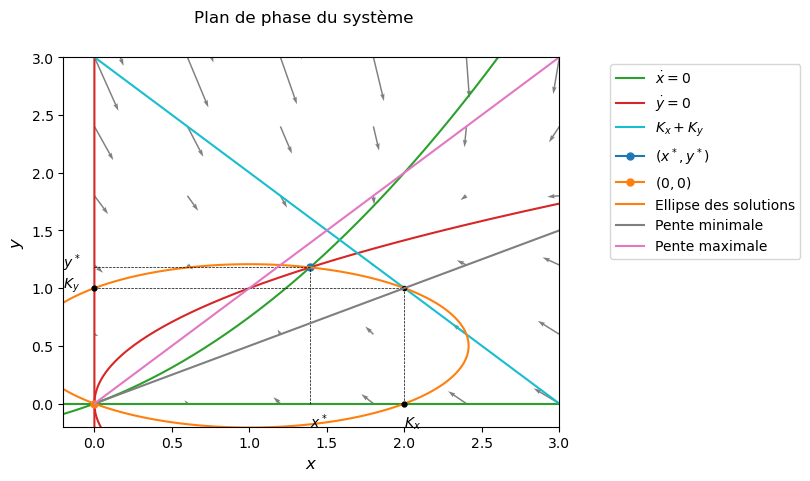

In [27]:
##On a le même code, voir en bas les changements:
#Définition du modèle et des paramètres :
def aug(etat,t,param):
    rx,ry,Kx,Ky,b=param
    x,y=etat
    s=[rx*x*(1-x/Kx)-b*(x-y),ry*y*(1-y/Ky)+b*(x-y)]
    return s 

# Temps d'intégration
ti = np.arange(0,10,0.01)

# Etats initiaux
x0=2
y0=0
e0=[x0,y0]

# Paramètres:
rx=0.5 #taux de croissance dans structure 1
ry=1 #taux de croissance dans structure 2
Kx=2
Ky=1
b=1

param_aug=np.array([rx,ry,Kx,Ky,b])

# Simulation:
s=odeint(aug,e0,ti,args=(param_aug,))

#On utilise numpy pour résoudre le polynôme, il faut donc défnir un monome x, un polynôme p et prendre ses solutions.
#Monome y
y=np.polynomial.Polynomial([0,1])

#Polynome :
pol = y*(rx*ry*((1/b)*((1/b)-(1/rx)-(1/ry))+1/(rx*ry))-1)+(y**2)*((rx*ry)/b)*((1/Ky)*((1/rx)-(1/b))+(1/Kx)*((1/ry)-(2/b)+(ry/(b**2))))+2*(y**3)*((rx*ry)/((b**2)*Kx*Ky))*(1-(ry/b))+(y**4)*((rx*(ry**2))/((b**3)*(Ky**2)*Kx))

#Solution qu'on obtient avec un masque booléen:
sol = pol.roots()[(np.isreal(pol.roots())) 
            *(pol.roots() > 0)]
yeq=sol[0].real

#On déduit x via sa définition par le système:
xeq=(ry*yeq*((1/ry)-(1/b)+(yeq/(b*Ky)))).real


#Affichage du nouveau graphe avec le point d'intersection:
#Plan de phase:
fig,ax=plt.subplots(1,1)
fig.suptitle('Plan de phase du système')

# Isocline nulles:
yt=np.arange(-10,10,0.01)
xt=np.arange(-10,10,0.01)
#Pour xdot = 0:

ax.plot(xt,xt*(1/b)*(rx*((xt/Kx)-1)+b),color='C2',label='$\dot x=0$')
ax.plot(np.zeros_like(yt),yt,color='C3')

#Pour ydot = 0:
ax.plot(yt*(1/b)*(ry*((yt/Ky)-1)+b),yt,color='C3',label='$\dot y=0$')
ax.plot(xt,np.zeros_like(xt),color='C2')

#On réduit la vue à ce qui nous intéresse:
ax.set_xlim(left=-1,right=3)
ax.set_ylim(top=3,bottom=-1)

#On nomme les axes:
ax.set_xlabel('$x$',fontsize='12')
ax.set_ylabel('$y$',fontsize='12')

#On trace la droite des capacités:
x=np.arange(0,10,0.01)
ax.plot(x,-x+Kx+Ky,label='$K_x+K_y$',color='C9')

#On plot les deux équilibres:
ax.plot(xeq.real,yeq.real,label='$(x^*,y^*)$',marker='.',markersize=10)
ax.plot(0,0,label='$(0,0)$',marker='.',markersize=10)

# Ajout du champ de vecteur via la fonction quiver :
xg=np.arange(0,5,0.6)
yg=np.arange(0,5,0.6)
X,Y=np.meshgrid(xg,yg)

dx,dy=aug([X,Y],0,param_aug)
ax.quiver(X,Y,dx,dy,angles='xy',color='grey',scale=80,width=0.003)

#On trace l'ellipse avec une technique utilisant la fonction contour:
xg2=np.arange(-5,5,0.01)
yg2=np.arange(-5,5,0.01)
X2,Y2=np.meshgrid(xg2,yg2)

X=rx*X2*(1-X2/Kx)
Y=ry*Y2*(1-Y2/Ky)
ax.contour(X2,Y2,(X+Y),[0],colors='C1')
ax.plot(0,0,color='C1',label='Ellipse des solutions')

#Localisation de la légende:
ax.legend(loc='lower left',fontsize = 8)

#On place les différents points d'intérêts...
xv=np.arange(0,10)
ax.plot(0,Ky,marker='.',markersize=7,color='k')
ax.plot(Kx,0,marker='.',markersize=7,color='k')
ax.plot(Kx,Ky,marker='.',markersize=6,color='k')

#...et on les relie aux axes:
xc=np.arange(0,Kx,0.01)
ax.plot(xc,Ky*np.ones_like(xc),linestyle='dashed',color='k',linewidth=0.5)
yc=np.arange(0,Ky,0.01)
ax.plot(Kx*np.ones_like(yc),yc,linestyle='dashed',color='k',linewidth=0.5)

#On nomme les points:
ax.text(-0.2,Ky,'$K_y$')
ax.text(Kx,-0.2,'$K_x$')

#On place les points d'équilibres :
ys=np.arange(0,yeq,0.01)
xs=np.arange(0,xeq,0.01)
ax.plot(xeq*np.ones_like(ys),ys,linestyle='dashed',color='k',linewidth=0.5)
ax.plot(xs,yeq*np.ones_like(xs),linestyle='dashed',color='k',linewidth=0.5)
ax.text(-0.2,yeq,'$y^*$')
ax.text(xeq,-0.2,'$x^*$')

################## Nouveau :

#On trace les droites des pentes:
ax.plot(xg,Ky/Kx*xg,color='C7',label='Pente minimale')
ax.plot(xg,yg,color='C6',label='Pente maximale' )

#On déplace la légende hors de la figure:
ax.legend(bbox_to_anchor=(1, 0.5, 0.5, 0.5))

#On adapte la fenêtre:
ax.set_xlim(left=-0.2)
ax.set_ylim(bottom=-0.2)

### B) Animation:

Petite animation Geogebra pour bien voir en fonction de beta que l'équilibre vit sur l'ellipse:

In [30]:
#Technique pour utiliser une fenêtre geogebra:
import IPython.display as display
fig01 = """
<iframe width="800" height="600" src="https://www.geogebra.org/classic/msgycwj7" style="border: 1px solid black"></iframe>
"""
display.HTML(fig01)

### C) Stabilité des équilibres:


Il est clair que $(0,0)$ est instable et $(x^*,y^*)$ est stable (par le champ de vecteur). Mathématiquement : 
$$ 
\mathbb{J}=\left[\begin{array}{cc} 
\ r_x-\frac{2r_xx}{K_x}-\beta & \beta \\
\ \beta & r_y -\frac{2r_yy}{K_y}-\beta
\end{array}\right]
$$
 - et donc pour $(0,0)$:,
$$
\mathbb{J_{\vec{0}}}=\left[\begin{array} \\
\ r_x-\beta & \beta \\
\ \beta & r_y -\beta
\end{array}\right]
\\
\Leftrightarrow
\sigma_\mathbb{J} = (\lambda_1 = \frac{r_x+r_y-2\beta-2\beta\sqrt{\frac{(r_x-r_y)^2}{4\beta^2}+1}}{2},\lambda_2=\frac{r_x+r_y-2\beta+2\beta\sqrt{\frac{(r_x-r_y)^2}{4\beta^2}+1}}{2})
$$
  et on a ainsi,
$$
\lambda_2 > 0
$$

  Donc $(0,0)$ est bien instable, $\forall (x_0,y_0) \in \mathbb{R^2_+}$.
- et pour $(x^*,y^*)$ après simplification (et en abandonnant les * par comodité) : 
$$ \mathbb{J_{x^*,y^*}} = \left[\begin{array} \\
\ -\frac{\beta y}{x}-\frac{r_xx}{K_x} & \beta \\
\ \beta & -\frac{\beta x}{y}-\frac{r_yy}{K_y}
\end{array}\right]
\\
$$
Il est alors facile de vérifier que la trace de cette matrice est négative pour tout $(x_0,y_0)$ et que le déterminant est positif pour tout $(x_0,y_0)$.
Ainsi, $(x^*,y^*)$ est bien stable, $\forall (x_0,y_0) \in \mathbb{R^2_+}$.


## 2) **Etude d'une population répartie en deux structures spatiales avec migration assymétrique:** 

*Cette analyse s'appuie sur celle effectuée par [R.Arditi et al.](https://doi.org/10.1016/j.tpb.2017.12.006) en 2017 et celle de [Gao](https://doi.org/10.1016/j.tpb.2022.05.003) et a été retravaillée pour coller au modèle d'augmentorium.*

On va considérer le système d'augmentorium suivant :  
$$ 
\left\{\begin{array}{1}
\dot x = r_xx(1-\frac{x}{K_x})+\beta\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)\\
\dot y = r_yy(1-\frac{y}{K_y})+\beta\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)
\end{array}\right.
$$

avec $ \dot x $ la population de ravageurs dans la culture et $ \dot y $ celle dans l'augmentorium.  
$\beta$ est alors le taux de migration global, ie la force que met l'agriculteur à ramasser ses fruits et $\gamma_x,\gamma_y$ caractérisent l'assymétrie entre la migration. 
Dans le cas de l'augmentorium on a forcément $\gamma_x<<\gamma_y$ et $r_x<r_y$ et en fonction du type de culture une condition sur la carrying capacity ($K_x<K_y$ ou $K_x>K_y$).
  
Dans la lutte biologique ce qui va particulièrement nous intéresser est d'obtenir un système déflationiste avec le nombre de ravageurs dans la culture qui est inférieur à sa capacité ($x^*<K_x$). 

### A) Dynamique : 

Text(0, 0.5, 'Densité de pop.')

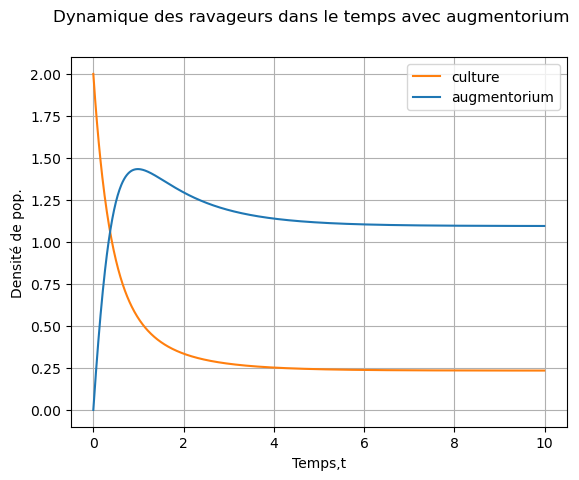

In [31]:
# Définition du modèle:
def aug(etat,t,param):
    rx,ry,Kx,Ky,b,gx,gy=param
    x,y=etat
    s=[rx*x*(1-x/Kx)+b*(y/gy-x/gx),ry*y*(1-y/Ky)+b*(x/gx-y/gy)]
    return s 

# Temps d'intégration:
ti = np.arange(0,10,0.01)

# Etats initiaux:
x0=2
y0=0
e0=[x0,y0]

# Paramètres: 

rx=0.5
ry=1
Kx=2
Ky=1
b=1
gx=0.5
gy=3

param_aug=np.array([rx,ry,Kx,Ky,b,gx,gy])

# Simulation:
s=odeint(aug,e0,ti,args=(param_aug,))

# Plot de la dynamique:
fig,ax=plt.subplots(1,1)
fig.suptitle('Dynamique des ravageurs dans le temps avec augmentorium')
ax.plot(ti,s[:,0],color='C1',label='culture')
ax.plot(ti,s[:,1],color='C0',label='augmentorium')

# Ajout d'élements:
ax.grid()
ax.legend()
ax.set_xlabel('Temps,t')
ax.set_ylabel('Densité de pop.')

On observe une hausse de la quantité de population dans l'augmentorium et une baisse de la population dans la culture.   
On voit qu'il se met en place un équilibre avec plus de population dans l'augmentorium que dans la culture.  
On observe que  on a la somme des équilibres qui est plus petite que celle des capacités et on a bien que la population de ravageurs dans la culture est plus basse que sa capacité.

### B) Plan de phase :

$$ 
\left\{\begin{array}{1}
\dot x = 0 \Leftrightarrow  y^*=\gamma_y\left(\frac{x}{\gamma_x}-\frac{r_xx}{\beta}\left(1-\frac{x}{K_x}\right)\right)\\
\dot y =0 \Leftrightarrow   x^*=\gamma_x\left(\frac{y}{\gamma_y}-\frac{r_yy}{\beta}\left(1-\frac{y}{K_y}\right)\right)
\end{array}\right.
$$

On voit tout de suite qu'on a deux paraboles qui se croisent en $(0,0)$ et en $(x^*,y^*)$. On va donc avoir deux équilibres, ceux ci vivent sur une ellipse de même équation qu'en 1). En effet, cette ellipse ne dépend d'aucun des paramètres de migration. En fonction des racines des polynômes on a des profils de paraboles différents : 

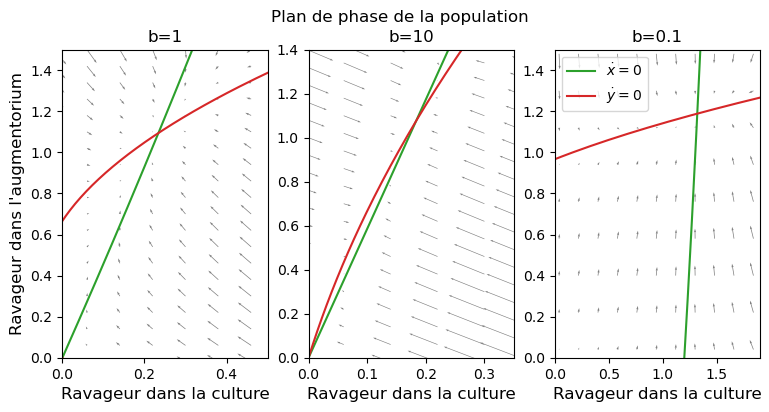

In [32]:
#On crée la figure avec les 3 sous figures:
fig2,(ax2,ax3,ax4)=plt.subplots(1,3,figsize=(9,4))
fig2.suptitle('Plan de phase de la population')
ax2.set_title('b=1')
ax3.set_title('b=10')
ax4.set_title('b=0.1')

#Plan de phase 1:#
# Paramètres: 
rx1=0.5
ry1=1
Kx1=2
Ky1=1
b1=1
gx1=0.5
gy1=3

param_aug1=np.array([rx1,ry1,Kx1,Ky1,b1,gx1,gy1])

# Isocline nulles:
xt=np.arange(0,10,0.01)
yt=np.arange(0,10,0.01)

#xdot = 0 
ax2.plot(xt,gy1*(xt/gx1-rx1*xt/b1*(1-xt/Kx1)),color='C2',label='xdot=0')

#ydot = 0
ax2.plot(gx1*(yt/gy1-ry1*yt/b1*(1-yt/Ky1)),yt,color='C3',label='ydot=0')

#Illustration de la figure:
ax2.set_xlim(left=0,right=0.5)
ax2.set_ylim(top=1.5,bottom=0)
ax2.set_xlabel('Ravageur dans la culture',fontsize='12')
ax2.set_ylabel('Ravageur dans l\'augmentorium',fontsize='12')

#Ajout du champ de vecteur
xg=np.arange(-0.5,3,0.08)
yg=np.arange(-0.5,3,0.08)
X,Y=np.meshgrid(xg,yg)

#On utilise quiver:
dx,dy=aug([X,Y],0,param_aug1)
ax2.quiver(X,Y,dx,dy,angles='xy',color='grey',scale=15,width=0.0035)

#Plan de phase 2:#
#Paramètres: 
rx2=0.5
ry2=1
Kx2=2
Ky2=1
b2=10
gx2=0.5
gy2=3

param_aug2=np.array([rx2,ry2,Kx2,Ky2,b2,gx2,gy2])  

#Isocline nulles:
#xdot = 0
ax3.plot(xt,gy2*(xt/gx2-rx2*xt/b2*(1-xt/Kx2)),color='C2',label='xdot=0')

#ydot = 0
ax3.plot(gx2*(yt/gy2-ry2*yt/b2*(1-yt/Ky2)),yt,color='C3',label='ydot=0')

#Illustration de la figure:
ax3.set_xlim(left=0,right=0.35)
ax3.set_ylim(top=1.4,bottom=0)
ax3.set_xlabel('Ravageur dans la culture',fontsize='12')


#Ajout du champ de vecteur
xg=np.arange(-0.5,3,0.08)
yg=np.arange(-0.5,3,0.08)
X,Y=np.meshgrid(xg,yg)

#On utilise quiver:
dx,dy=aug([X,Y],0,param_aug2)
ax3.quiver(X,Y,dx,dy,angles='xy',color='grey',scale=40,width=0.003)

#Plan de phase 3:
#Paramètres: 
rx3=0.5
ry3=1
Kx3=2
Ky3=1
b3=0.1
gx3=0.5
gy3=3

param_aug3=np.array([rx3,ry3,Kx3,Ky3,b3,gx3,gy3])

#Isocline nulles:
#xdot = 0 
ax4.plot(xt,gy3*(xt/gx3-rx3*xt/b3*(1-xt/Kx3)),color='C2',label='$\dot x=0$')

#ydot = 0 
ax4.plot(gx3*(yt/gy3-ry3*yt/b3*(1-yt/Ky3)),yt,color='C3',label='$\dot y=0$')

#Illustration:
ax4.set_xlim(left=0,right=1.9)
ax4.set_ylim(top=1.5,bottom=0)
ax4.set_xlabel('Ravageur dans la culture',fontsize='12')

# Ajout du champ de vecteur
xg=np.arange(-0.5,3,0.18)
yg=np.arange(-0.5,3,0.18)
X,Y=np.meshgrid(xg,yg)

dx,dy=aug([X,Y],0,param_aug3)
ax4.quiver(X,Y,dx,dy,angles='xy',color='grey',scale=10,width=0.0035)

#On légende:
ax4.legend()

On voit que $(0,0)$ est instable et $(x^*,y^*)$ est stable quelque soit la configuration (par le champ de vecteurs). Ceci montre que la population tend à se stabiliser entre l'augmentorium et l'extérieur. Dans ce modèle on a jamais disparition du ravageur.

On va calculer numériquement le point d'équilibre $(x^*,y^*)$ en considérant le croisement des paraboles verte et rouge, on obtient alors : 
$$
\frac{r_xr_y\gamma_x\gamma_y}{\beta}-\gamma_yr_y-\gamma_xr_x + y\left[\frac{r_y\gamma_y}{K_y}-\frac{r_xr_y\gamma_x\gamma_y}{\beta K_y} + \frac{r_xr_y^2\gamma_x^2\gamma_y}{\beta^2K_x}+\frac{r_x\gamma_x^2}{\gamma_yK_x}-\frac{2r_xr_y\gamma_x^2}{\beta K_x}   \right] + \frac{2r_yr_x\gamma_xy^2}{\beta K_xK_y}\left(1-\frac{r_y\gamma_y}{\beta}\right) + \frac{r_xr_y^2\gamma_x^2\gamma_yy^3}{\beta^2K_xK_y^2} = 0
$$

qu'on va résoudre par numpy.

Comme en 1) on trace le plan de phase complet avec l'ellipse, la droite de la somme des capacités et de la parabole $\dot x=0$ en $\beta=0$ et la parabole en $\beta=+\infty$. L'équilibre va se répartir sur l'ellipse entre les deux paraboles :  

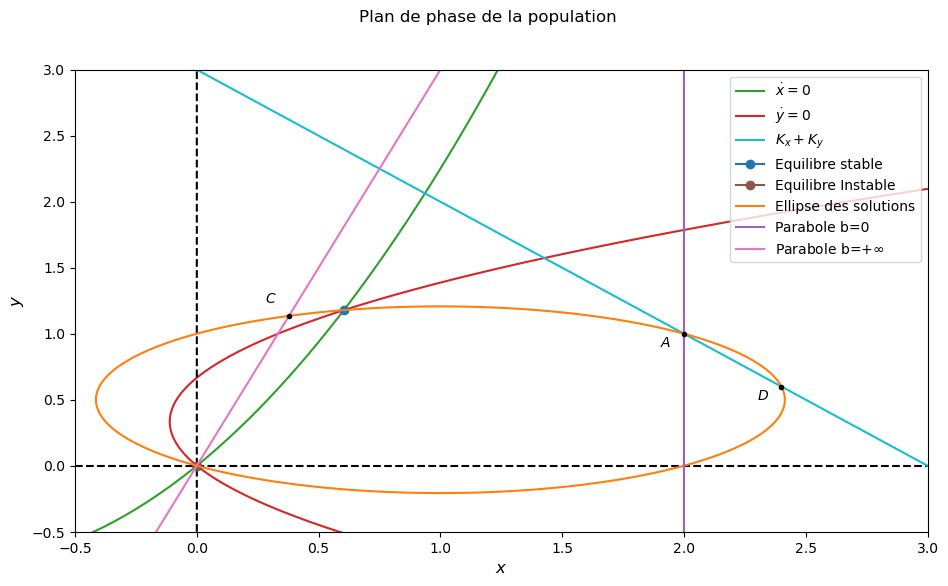

In [33]:
#On crée la figure:
fig2,ax2=plt.subplots(1,1,figsize=(11,6))
fig2.suptitle('Plan de phase de la population')

#Plan de phase 1:
# Paramètres: 
rx=0.5
ry=1
Kx=2
Ky=1
b=1
gx=1
gy=3

param_aug=np.array([rx,ry,Kx,Ky,b,gx,gy])

# Isocline nulles:
xt=np.arange(-10,10,0.01)
yt=np.arange(-10,10,0.01)

#xdot = 0 
ax2.plot(xt,gy*(xt/gx-rx*xt/b*(1-xt/Kx)),color='C2',label='$\dot x=0$')

#ydot = 0
ax2.plot(gx*(yt/gy-ry*yt/b*(1-yt/Ky)),yt,color='C3',label='$\dot y=0$')

#Cadrage:
ax2.set_xlim(left=-0.50,right=3)
ax2.set_ylim(top=3,bottom=-0.50)
ax2.set_xlabel('$x$',fontsize='12')
ax2.set_ylabel('$y$',fontsize='12')

#Axe x et y:
ax2.plot(xt,np.zeros_like(xt),color='k',linestyle='dashed')
ax2.plot(np.zeros_like(yt),yt,color='k',linestyle='dashed')

#Droite capacité:
x=np.arange(0,10,0.01)
ax2.plot(x,-x+Kx+Ky,label='$K_x+K_y$',color='C9')

#Points d'équilibres, utilisation de numpy : monome, polynome et racines:
#Calcul:
#Monome y
x=np.polynomial.Polynomial([0,1])

#Polynome :
pol = -gy*ry-gx*rx+(rx*ry*gx*gy)/b + x*((ry*gy)/(Ky*b)-(ry*rx*gy*gx)/(b*Ky) + rx*ry**2*gx**2*gy/(b**2*Kx)+rx*gx**2/(gy*Kx) - 2*rx*ry*gx**2/(b*Kx))+ (x**2)*2*(ry*rx*gx)/(b*Kx*Ky)*(1-ry*gy/b) + (x**3)*gy*rx*((ry*gx)**2)/(b**2*Kx*Ky**2)

#Solution
sol = pol.roots()[(np.isreal(pol.roots())) 
            *(pol.roots() > 0)]
yeq=sol[0].real

#Calcul de x avec sa définition:
xeq=gx*(yeq/gy-ry*yeq/b*(1-yeq/Ky))

#Plot des équilibres:
ax2.plot(xeq,yeq,label='Equilibre stable',marker='.',markersize=12)
ax2.plot(0,0,label='Equilibre Instable',marker='.',markersize=12,color='C5')

#Ellipse:
xg2=np.arange(-5,5,0.01)
yg2=np.arange(-5,5,0.01)
X2,Y2=np.meshgrid(xg2,yg2)

X=rx*X2*(1-X2/Kx)
Y=ry*Y2*(1-Y2/Ky)
ax2.contour(X2,Y2,(X+Y),[0],colors='C1')
ax2.plot(0,0,color='C1',label='Ellipse des solutions')

#Parabole xdot=0 b=0:
ax2.plot(Kx*np.ones_like(xt),xt,color='C4',label='Parabole b=0')

#Parabole xdot=0 b=+inf:
ax2.plot(xt,xt*gy/gx,color='C6',label='Parabole b=$+\infty$')

#A:
ax2.plot(Kx,Ky,color='black',marker='.')
ax2.text(Kx-0.1,Ky-0.1,'$A$')

#B:
ax2.plot(Kx,gy*Kx/gx,color='black',marker='.')

#C:
ax2.plot(((gx/gy)*rx+ry)/((gx/gy)*rx/Kx+(gy/gx)*ry/Ky),((gy/gx)*ry+rx)/((gx/gy)*rx/Kx+(gy/gx)*ry/Ky),color='black',marker='.')
ax2.text(((gx/gy)*rx+ry)/((gx/gy)*rx/Kx+(gy/gx)*ry/Ky)-0.1,((gy/gx)*ry+rx)/((gx/gy)*rx/Kx+(gy/gx)*ry/Ky)+0.1,'$C$')

#D:
ax2.plot(ry*Kx*(Kx+Ky)/(rx*Ky+ry*Kx),rx*Ky*(Kx+Ky)/(rx*Ky+ry*Kx),color='black',marker='.')
ax2.text(ry*Kx*(Kx+Ky)/(rx*Ky+ry*Kx)-0.1,rx*Ky*(Kx+Ky)/(rx*Ky+ry*Kx)-0.1,'$D$')

#Légende:
ax2.legend()

*⚠️* Tout ceci vaut pour $r_x<r_y$ ie on prend l'ellipse dans un seul sens (voir animation en D).

---
- Si on note $A$ l'intersection entre la parabole en $0$ et l'ellipse et $B$ l'intersection entre la parabole en $0$ et en $+\infty$ alors pour que $x^* < K_x$ (ce que l'on veut) il faut que la coordonnée en $y$ de $B$ soit supérieur à celle de $A$.

  Le point $A$ est défini par :
  $A=(K_x,K_y)$

  Le point $B$ est défini par :
  $B=\left(K_x,\frac{\gamma_yK_x}{\gamma_x}\right)$

  Autrement dit, **si** $\frac{\gamma_y}{\gamma_x}>\frac{K_y}{K_x}$ alors on a toujours l'augmentorium qui est efficace, ie le système est déflationiste quelque soit le taux de migration $\beta$.
  
  
---   
- Si on note $C$ l'intersection entre l'ellipse et la parabole en $+\infty$ on a alors la valeur de l'équilibre en $\beta =+\infty$.
  
  Le point $C$ est défini par :
  $C=\left(\frac{\left(\frac{\gamma_x}{\gamma_y}\right)r_x + r_y}{\left(\frac{\gamma_x}{\gamma_y}\right)\frac{r_x}{K_x}+\left(\frac{\gamma_y}{\gamma_x}\right)\frac{r_y}{K_y}} , \frac{\left(\frac{\gamma_y}{\gamma_x}\right)r_y + r_x}{\left(\frac{\gamma_x}{\gamma_y}\right)\frac{r_x}{K_x}+\left(\frac{\gamma_y}{\gamma_x}\right)\frac{r_y}{K_y}} \right)$
  
  Maintenant notons $D$ la valeur de l'intersection entre le droite des capacités et l'ellipse.
  
  Le point $D$ est défini par :
  $D=\left(\frac{r_yK_x(K_x+K_y)}{r_xK_y+r_yK_x} , \frac{r_xK_y(K_x+K_y)}{r_xKy+r_yK_x}\right) $  
  
  Ainsi, quand $\beta$ augmente le point d'équilibre se déplace entre A et C. On voit donc que l'équilibre peut soit être tout le   temps déflationiste si C est avant A (point précédent) sur l'ellipse soit être constamment inflationiste si C est entre A et D soit être les deux   si C est après D.
  
  Voyons ceci en terme de coefficient de droite, on a alors les exactes mêmes conditions mais sur les pentes des droites passant  par ces points, qu'on peut calculer.
  On a déja par le premier point la condition sur les paramètres pour avoir le système déflationiste.
  
  **Si** $\frac{\gamma_y}{\gamma_x} < \frac{r_xK_y}{r_yK_x}$ alors on a des équilibres à la fois inflationiste et déflationiste. En effet ceci traduit que C est après D, graphiquement on voit que l'équilibre est au début au dessus de la droite cyan et à la fin en dessous (après avoir passé D).  
  **Si** $\frac{r_xK_y}{r_yK_x} < \frac{\gamma_y}{\gamma_x} < \frac{K_y}{K_x}$ alors les équilibres sont constamment inflationiste. 

---

-  Enfin on observe que si la droite cyan est tangente à l'ellipse alors on a que le système est constamment déflationiste. Ceci correspond au même calcul que dans le 1) et on trouve que **si** $r_x=r_y$ le système est tout le temps déflationiste pour tout $\beta$.

---

Maintenant si on prend $r_x>r_y$ on a un autre cas qui apparaît. En effet, et on le voit bien sur l'animation en D), on peut alors avoir C entre D et A avec C plus haut que A et ainsi on peut avoir un cas où le système est complètement inflationiste avec des valeurs de la somme des équilibres plus grands que C.
Cette situation ne nous intéresse que peu car ce n'est pas un cas qui est biologiquement réaliste.

#### Preuves mathématiques :

- Point $B$:  
  La première coordonnée est forcément $K_x$ car on considère le croisement avec la parabole en $\beta = 0$.  
  On sait que la parabole en $\beta = +\infty$ est définie par $y = \frac{\gamma_y}{\gamma_x}x$.  
  On a le résultat pour $x=K_x$.
  
- Point $C$:  
  La parabole en $\beta = +\infty$
 est définie par $y = \frac{\gamma_y}{\gamma_x}x$ et l'ellipse par $r_xx\left(1-\frac{x}   {K_x}\right) + r_yy\left(1-\frac{y}{K_y}\right) = 0 $. Il suffit de remplacer dans l'expression de l'ellipse la valeur de y donnée par la parabole pour trouver la première coordonnée.   
  Pour trouver la deuxième on utilise l'expression de la parabole.

- Point $D$:
  On fait la même que précédemment. La droite des capacités est définie par $y= -x +K_x+K_y$ qu'on remplace dans l'expression de l'ellipse pour trouver la première coordonnée (après simplifacation). La deuxième est déduite de la la première grâce à l'expression de la droite. 
  
Pour les conditions sur les équilibres on se rappelle que la pente de  la parabole en $\beta = +\infty$ est définie par $\frac{\gamma_y}{\gamma_x}$. Ainsi, quand cette pente est inférieure à celle de la droite passant par le point $D$ (qui a une pente de $\frac{r_xK_y}{r_yK_x}$) on a soit déflationiste soit inflationiste. On a donc pour condition $\frac{\gamma_y}{\gamma_x} < \frac{r_xK_y}{r_yK_x}$.  
Ensuite pour que le système soit entièrement inflationiste on veut que la pente de $\beta = +\infty$ soit entre celle de la droite passant par $D$ et celle passant par $A$ (première condition détaillée au premier point de l'analyse. Ceci donne le résultat.


### C) Illustration des propositions et applications théorique à l'augmentorium :

#### a) Illustration

---

On va tracer la somme des équilibres en fonction de $\beta$, ceci permet de voir, en tracant $K_x+K_y$, pour quelle migration le système est déflationiste. On teste les conditions sur les paramètres trouvées en B.

Text(0.5, 1.0, 'Inflation')

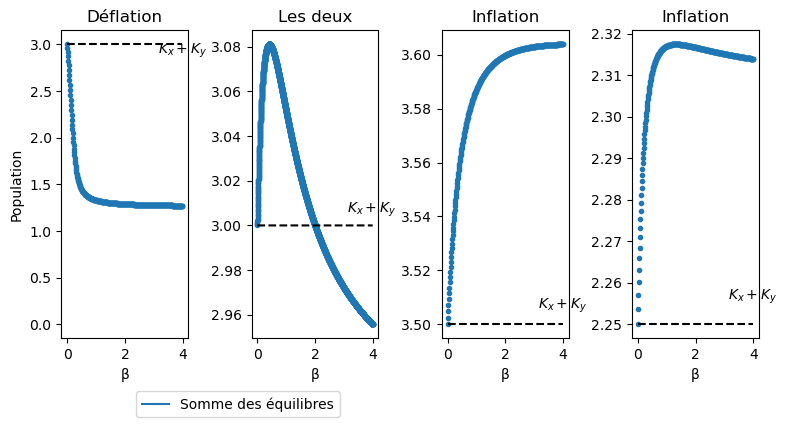

In [29]:
#Définition d'une fonction qui prend en compte le changement de migration:
def aug2(etat,t,param,h):
    rx,ry,Kx,Ky,gx,gy=param
    b=h
    x,y=etat
    s=[rx*x*(1-x/Kx)+b*(y/gy-x/gx),ry*y*(1-y/Ky)+b*(x/gx-y/gy)]
    return s 

#Définition des paramètres:
#1:
rx1 = 0.5
ry1 = 1
Kx1 = 2
Ky1 = 1
gx1 = 0.5
gy1 = 3

param1=np.array([rx1,ry1,Kx1,Ky1,gx1,gy1])

#2:
rx2 = 0.5
ry2 = 1
Kx2 = 2
Ky2 = 1
gx2 = 5
gy2 = 1

param2=np.array([rx2,ry2,Kx2,Ky2,gx2,gy2])

#3:
rx3 = 1
ry3 = 2
Kx3 = 2
Ky3 = 1.5
gx3 = 2
gy3 = 1

param3=np.array([rx3,ry3,Kx3,Ky3,gx3,gy3])

#4:
rx4 = 2
ry4 = 1
Kx4 = 1
Ky4 = 1.25
gx4 = 0.5
gy4 = 1

param4=np.array([rx4,ry4,Kx4,Ky4,gx4,gy4])

#Temps d'intégration suffisament large pour atteindre l'équilibre:
t=np.arange(0,100,0.01)

#Condition initiale:
e0=[1,1]

#Figure:
fig,(ax,ax1,ax2,ax3)=plt.subplots(1,4,figsize=(9,4))
plt.subplots_adjust(wspace=0.5)

#Boucle pour plot en fonction de beta:
for i in np.arange(0,4,0.01):
    s=odeint(aug2,e0,t,args=(param1,i)) #On calcule pour chaque beta l'équilibre
    ax.plot(i,s[-1][0]+s[-1][1],marker='.',color='C0') #On plot un point qui correspond à la valeur de la somme des éq. en fonction de beta
    s2=odeint(aug2,e0,t,args=(param3,i))
    ax2.plot(i,s2[-1][0]+s2[-1][1],marker='.',color='C0')
    s3=odeint(aug2,e0,t,args=(param4,i))
    ax3.plot(i,s3[-1][0]+s3[-1][1],marker='.',color='C0')
    
    
for i in np.arange(0,4,0.001):
    s1=odeint(aug2,e0,t,args=(param2,i))
    ax1.plot(i,s1[-1][0]+s1[-1][1],marker='.',color='C0')

#Plot de la droite Kx+Ky:    
xt=np.arange(0,4,0.01)
xt2=np.arange(0,4,0.001)

ax.plot(xt,(Kx1+Ky1)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax.text(3.15,Kx1+Ky1-0.1,'$K_x+K_y$')
ax1.plot(xt2,(Kx2+Ky2)*np.ones_like(xt2),linestyle='dashed',color='k',markersize='6')
ax1.text(3.10,Kx2+Ky2+0.006,'$K_x+K_y$')
ax2.plot(xt,(Kx3+Ky3)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax2.text(3.12,Kx3+Ky3+0.006,'$K_x+K_y$')
ax3.plot(xt,(Kx4+Ky4)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax3.text(3.12,Kx4+Ky4+0.006,'$K_x+K_y$')

#Légendes:
ax.set_xlabel('β')
ax1.set_xlabel('β')
ax2.set_xlabel('β')
ax3.set_xlabel('β')
ax.set_ylabel('Population')
ax.plot(0,0,color='C0',label='Somme des équilibres')

#On déplace la légende hors de la figure:
ax.legend(bbox_to_anchor=(1.75, -0.65, 0.5, 0.5))

#Titres:
ax.set_title('Déflation')
ax1.set_title('Les deux')
ax2.set_title('Inflation')
ax3.set_title('Inflation')


On a donc bien les quatre situations en fonction des paramètres qu'on choisit.

---

#### b) Applications théoriques à l'augmentorium:

---

L'augmentorium est basé sur l'assymétrie de la migration, les fuites (migration de l'augmentorium vers la culutre) doivent êtres empêchées pour maximiser la performance. On peut modéliser la somme des équilibres et l'équilibre dans la culutre seule en fonction de ce taux de fuite pour avoir une preuve mathématique.  
Les petites valeurs $\gamma_y$ correspondent à une forte fuite et inversement.  

Text(0, 0.5, 'Densité de pop.')

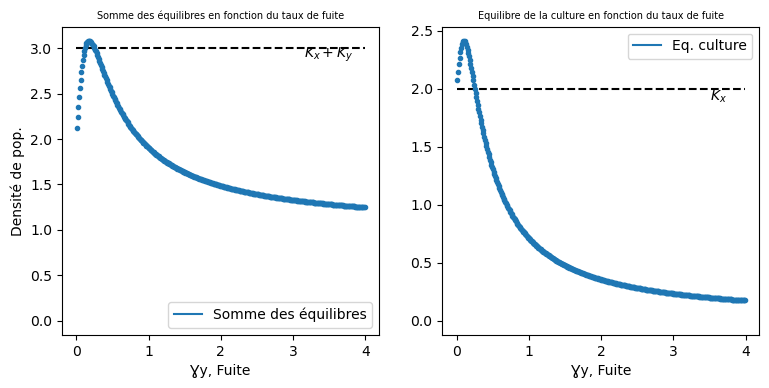

In [8]:
#Définition d'un nouveau modèle qui prend en compte le changement de gy:
def aug3(etat,t,param,h):
    rx,ry,Kx,Ky,gx,b=param
    gy=h
    x,y=etat
    s=[rx*x*(1-x/Kx)+b*(y/gy-x/gx),ry*y*(1-y/Ky)+b*(x/gx-y/gy)]
    return s 

#Définition des paramètres:
#1:
rx1 = 0.5
ry1 = 1
Kx1 = 2
Ky1 = 1
gx1 = 0.5
b = 1

param1=np.array([rx1,ry1,Kx1,Ky1,gx1,b])

#Temps d'intégration assez large pour atteindre l'éq :
t=np.arange(0,100,0.01)

#Conditions initiales:
e0=[1,1]

#Figure:
fig,(ax,ax1)=plt.subplots(1,2,figsize=(9,4))

#Droite de la somme des capacités:
xt=np.arange(0,4,0.01)

ax.plot(xt,(Kx1+Ky1)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax.text(3.15,Kx1+Ky1-0.1,'$K_x+K_y$')

ax1.plot(xt,Kx1*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax1.text(3.5,Kx1-0.1,'$K_x$')

#Boucle qui calcule l'équilibre et qui plot un point en fonction des valeurs du taux de fuite:
for i in np.arange(0.01,4,0.01):
    s=odeint(aug3,e0,t,args=(param1,i))
    ax.plot(i,s[-1][0]+s[-1][1],marker='.',color='C0')
    ax1.plot(i,s[-1][0],marker='.',color='C0')

#Légendes:
ax1.set_xlabel('Ɣy, Fuite')
ax.set_xlabel('Ɣy, Fuite')
ax.plot(0,0,color='C0',label='Somme des équilibres')
ax1.plot(0,0,color='C0',label='Eq. culture')

ax.set_title('Somme des équilibres en fonction du taux de fuite',fontsize=7)
ax1.set_title('Equilibre de la culture en fonction du taux de fuite',fontsize=7)   
ax.legend()
ax1.legend()
ax.set_ylabel("Densité de pop.")

On observe que la somme des équilibres de la population de ravageurs en fonction du taux de fuite a une forme que nous n'avions pas eu. Il est possible en passant par l'animation geogebra de voir ceci en modifiant le taux de fuite. On a pour des fortes fuites un système déflationiste, puis une petite zone inflationiste et enfin de nouveau une zone déflationiste. Ceci est paradoxal car on est entrain de dire que un fort taux de fuite encourage une déflation du système et donc une efficacité de la technique de l'augmentorium.   
Il faut donc chercher plus en détail et exprimer l'équilibre dans la culture en fonction de la fuite. En effet, c'est ce qui nous intéresse le plus car l'équilibre dans l'augmentorium n'est pas important pour la lutte biologique.  
On voit que l'équilibre dans la culture est d'abord inflationiste pour des forts taux de fuites et ensuite déflationiste pour des taux de fuites faibles. On a ici le résultat logique auquel on s'attendait qui est que l'augmentorium n'est pas efficace si la fuite est trop forte.  
On a même que l'augmentorium est négatif pour la culture si le taux de fuite n'est pas correctement géré.


---

Si on considère une situtation d'augmentorium on a $r_x<r_y$ et $\gamma_x << \gamma_y$. En fonction des cultures on pourra avoir des rapport de capacités différentes :

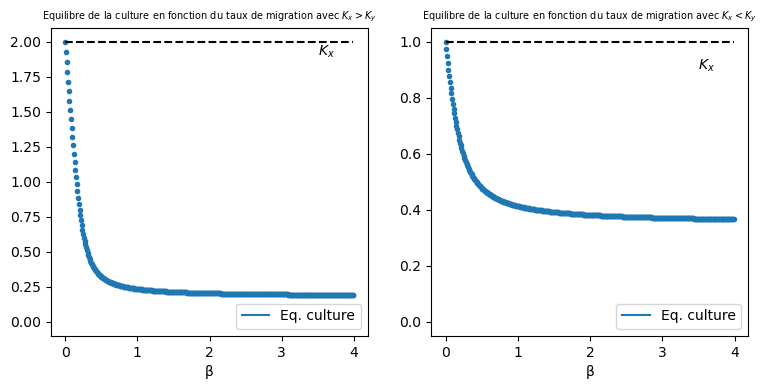

In [42]:
#Figure:
fig,(ax,ax1)=plt.subplots(1,2,figsize=(9,4))
ax.set_title('Equilibre de la culture en fonction du taux de migration avec $K_x>K_y$',fontsize=7)
ax1.set_title('Equilibre de la culture en fonction du taux de migration avec $K_x<K_y$',fontsize=7)  

#Fonction qui prend en compte l'actualisation de beta:
def aug4(etat,t,param,h):
    rx,ry,Kx,Ky,gx,gy=param
    b=h
    x,y=etat
    s=[rx*x*(1-x/Kx)+b*(y/gy-x/gx),ry*y*(1-y/Ky)+b*(x/gx-y/gy)]
    return s 

#Définition des paramètres:
#1:
rx1 = 0.5
ry1 = 1
Kx1 = 2
Ky1 = 1
gx1 = 0.5
gy1 = 3

param1=np.array([rx1,ry1,Kx1,Ky1,gx1,gy1])

#2:
rx2 = 0.5
ry2 = 1
Kx2 = 1
Ky2 = 2
gx2 = 0.5
gy2 = 3

param2=np.array([rx2,ry2,Kx2,Ky2,gx2,gy2])

#Temps d'intégration:
t=np.arange(0,100,0.01)

#Conditions initiales:
e0=[1,1]

#Boucle en fonction de beta
for i in np.arange(0,4,0.01):
    s=odeint(aug4,e0,t,args=(param1,i))
    ax.plot(i,s[-1][0],marker='.',color='C0')
    s1=odeint(aug4,e0,t,args=(param2,i))
    ax1.plot(i,s1[-1][0],marker='.',color='C0')

#Droite Kx:
xt=np.arange(0,4,0.01)
ax.plot(xt,Kx1*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax.text(3.5,Kx1-0.1,'$K_x$')

ax1.plot(xt,Kx2*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax1.text(3.5,Kx2-0.1,'$K_x$')


#Légendes:
ax.set_xlabel('β')
ax1.set_xlabel('β')
ax.plot(0,0,color='C0',label='Eq. culture')
ax1.plot(0,0,color='C0',label='Eq. culture')

ax.legend()
ax1.legend()

On observe donc que quelque soit le type de culture, ce modèle nous dit que l'augmentorium est toujours efficace car on a toujours l'équilibre dans la culture qui est inférieur à la capacité totale de la culture et ce quelque soit le taux de migration.

---

### D) Animation : 

Petite animation Geogebra pour bien voir en fonction de $\beta$ que l'équilibre vit sur l'ellipse et pour tester les différentes propositions.

In [3]:
import IPython.display as display
fig01 = """
<iframe width="800" height="600" src="https://www.geogebra.org/classic/bhhpgtqv" style="border: 1px solid black"></iframe>
"""
display.HTML(fig01)

### E) Conclusion :

Ce modèle d'augmentorium avec pour hypothèse que le taux de croissance est supérieur dans l'augmentorium (biologiquement logique) permet d'apporter quelques perspectives.  

En effet, l'augmentorium impose la condition que $\gamma_x << \gamma_y$ et donc que $\frac{\gamma_y}{\gamma_x}>>1$. De plus la capacité K entre l'augmentorium et la culture diffère en fonction des types de cultures mais reste généralement proche entre les deux. Ainsi le rapport entre ces deux capacités est proche de 1 que ce soit inférieurement ou supérieurement. On a donc en permanence dans les cultures la condition $\frac{\gamma_y}{\gamma_x}>\frac{K_y}{K_x}$ ce qui implique une déflation de la somme des équilibres par rapport à la capacité totale. On a, de plus, vu que l'équilibre des cultures est tout le temps sous la capactié $K_x$.

Donc mathématiquement l'augmentorium semble efficace. Mais ce modèle omet un aspect important : les prédateurs des parasites, qui eux circulent librement et forment deux populations et imposent une mortalité aux ravageurs à la fois dans l'augmentorium et dans la culture.  
  
On va donc, en 3), établir un modèle qui prend en compte les parasites.

## 3) **Modèle simplifié de l'augmentorium :** 

### A) Définition du modèle :

Pour simuler on va partir du modèle suivant : 
$$ \left\{\begin{array}{1}
\dot x = r_xx\left(1-\frac{x}{K_x}\right)+\beta\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)-pxz \\
\dot y = r_yy\left(1-\frac{y}{K_y}\right)+\beta\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)-pyz \\
\dot z = z\left(n(x+y) - m\right)
\end{array}\right.
$$

avec:  
- $r_x$ le taux de croissance de x dans la culture,  
- $r_y$ le taux de croissance de y dans l'augmentorium,  
- $K_x$ la capacité maximale de la culture,  
- $K_y$ la capacité maximale de l'augmentorium,  
- $\beta$ la force de migration,  
- $\gamma_x$ le taux d'assymétrie de la migration culture vers augmentorium,  
- $\gamma_y$ le taux d'assymétrie de la migration augmentorium vers culture,  
- $p$ la prédation de $z$ sur $x$ ou $y$,
- $n$ le taux de conversion proie prédateur (naissance due à la prédation),  
- $m$ la mortalité des prédateurs $z$.

#### Justification du modèle et quelques hypothèses:

*On s'appuie sur un modèle inspiré par [Freedman et Waltman](http://dx.doi.org/10.1137/0132052) dans leur article de 1977.*  
  
C'est plus généralement un modèle à deux structures, la culture (x) et l'augmentorium (y) où les proies grandissent selon une croissance logistique et les prédateurs une réponse fonctionelle de type 1. On suppose que les prédateurs diffusent librement entre la culture et l'augmentorium (très proche de la [réalité](https://unt.univ-reunion.fr/fileadmin/Fichiers/UNT/UVED/IGAR/EN/00_chapitre_3_gen_caseWeb/res/8a.pdf)) d'où la considération d'une seule population.  

La migration est assymétrique entre la culture et l'augmentorium, plus forte de la culutre vers l'augmentorium donc $\gamma_x < \gamma_y$.  
On supposera que le taux de croissance dans la culture est plus faible que dans l'augmentorium, donc $r_x<r_y$, car l'environnement de l'augmentorium est bénéfique à la reproduction des ravageurs (chaleur, isolation, fruit disponible, fruits pourris).  

Le rapport entre la capacité de la culture et de l'augmentorium peut être différent en fonction du type de culture dans lequel on se place. En effet si la culture est remontante ie qu'elle produit tout au long de l'année, les apports de fruits dans l'augmentorium ne seront jamais excessifs par rapport au nombre de fruits à l'extérieur, impliquant une capacité maximale plus forte pour la culture ($K_x>K_y$). Par contre si la culture est non-remontante on aura énormément de fruits dans l'augmentorium sur une courte période impliquant une possible capacité maximale plus forte pour l'augmentorium ($K_x<K_y$).

On considère dans un premier temps que la prédation et les naissances sont égales entres les structures. Dans en second temps (en 4)) nous verrons l'analyse en prenant en compte que ces paramètres peuvent êtres différents.

Dans la suite nous étudierons le cas général mais il faut garder en tête que la situation de l'augmentorium impose des condtions qui vont venir restreindre nos résultats.

### B) Dynamique :

Text(0.5, 1.0, 'Disparition des parasites, maintien des ravageurs')

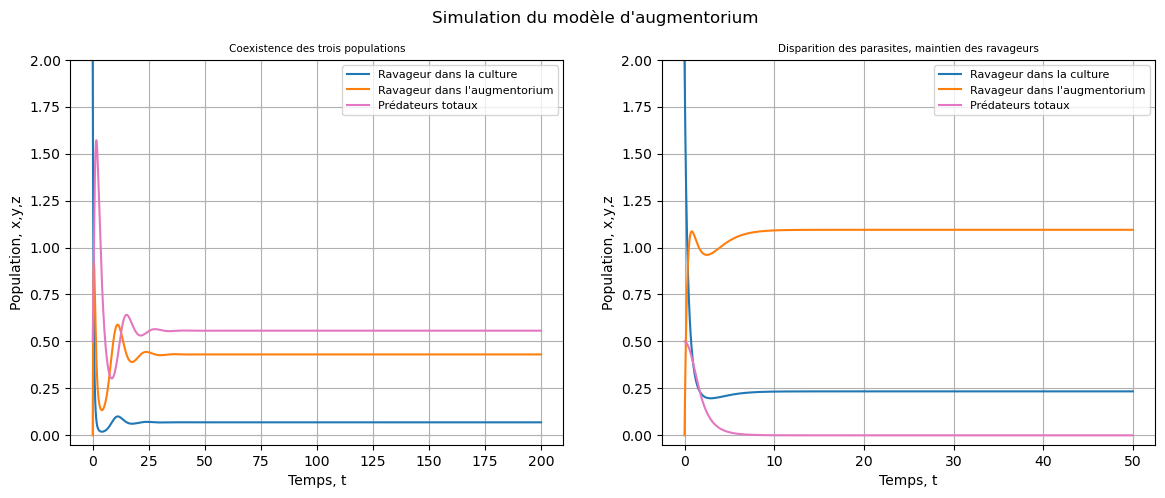

In [4]:
#Définition du modèle:
def a(etat,t,param):
    x,y,z=etat
    rx,Kx,ry,Ky,gx,gy,b,p,n,m = param
    xdot,ydot,zdot=[rx*x*(1-x/Kx)+b*(y/gy-x/gx)-p*z*x,ry*y*(1-y/Ky)+b*(x/gx-y/gy)-p*y*z,z*(n*(x+y)-m)]
    return [xdot,ydot,zdot]

#Paramètres Simulation 1: 
rx1=0.5
ry1=1
Kx1=2
Ky1=1
gx1=0.5
gy1=3
b1=1
p1=1
n1=1
m1=0.5

param_a1=np.array([rx1,Kx1,ry1,Ky1,gx1,gy1,b1,p1,n1,m1])

#Paramètres Simulation 2: 
rx2=0.5
ry2=1
Kx2=2
Ky2=1
gx2=0.5
gy2=3
b2=1
p2=1
n2=1
m2=2

param_a2=np.array([rx2,Kx2,ry2,Ky2,gx2,gy2,b2,p2,n2,m2])

#Temps d'intégration 1,2:
t1=np.arange(0,200,0.01)
t2=np.arange(0,50,0.01)

#Condition initiale de 1,2:
x0=2
y0=0
z0=0.5
c0=np.array([x0,y0,z0])

#Simulation 1,2:
s1=odeint(a,c0,t1,args=(param_a1,))
s2=odeint(a,c0,t2,args=(param_a2,))

#Plot de la figure: 
fig,ax = plt.subplots(1,2,figsize=(14,5))
fig.suptitle('Simulation du modèle d\'augmentorium')
plt.subplots_adjust(hspace=0.4)

#Plot de l'axe 1:
ax[0].plot(t1,s1[:,0],color='C0',label='Ravageur dans la culture')
ax[0].plot(t1,s1[:,1],color='C1',label='Ravageur dans l\'augmentorium')
ax[0].plot(t1,s1[:,2],color='C6',label='Prédateurs totaux')

#Plot de l'axe 2:
ax[1].plot(t2,s2[:,0],color='C0',label='Ravageur dans la culture')
ax[1].plot(t2,s2[:,1],color='C1',label='Ravageur dans l\'augmentorium')
ax[1].plot(t2,s2[:,2],color='C6',label='Prédateurs totaux')


#Légendes et titres:
ax[0].set_ylabel('Population, x,y,z')
ax[0].legend(fontsize=8)
ax[0].grid()
ax[0].set_xlabel('Temps, t')
ax[0].set_ylim(top=2,bottom=-0.05)
ax[0].set_title('Coexistence des trois populations',fontsize=7.5)

ax[1].set_xlabel('Temps, t')
ax[1].set_ylabel('Population, x,y,z')
ax[1].legend(fontsize=8)
ax[1].grid()
ax[1].set_ylim(top=2,bottom=-0.05)

ax[1].set_title('Disparition des parasites, maintien des ravageurs',fontsize=7.5)

On a utilisé des paramètres différents pour obtenir ces simulations. A gauche on a un taux de mortalité $m = 0.5$ et à droite on a un taux de mortalité $m = 2$. Ainsi, on a logiquement une extinction des prédateurs à droite car leurs taux de mortalité est trop fort.  
Ce système semble donc avoir deux situtations (avec ou sans parasites) avec à chaque fois deux équilibres.   
Le système à gauche se stabilise avec peu de population dans la culture et un fort taux de parasites. On voit que le système à droite est équivalent à la dynamique de celui en 2).

### C) Plan de phase :

On trace les surfaces correspondant à $\dot x = 0  ;  \dot y = 0  ; \dot z = 0$, quand $\dot z = 0 $ on a soit le plan $z=0$ soit le plan $y=\frac{m}{n}-x$ (si $z \ne 0$).   
On a donc mis en valeur en vert l'intersection de la surface définie par $\dot x =0$ avec les deux plans précédents.  
On a aussi tracé en rouge l'intersection de la surface définie par $\dot y = 0$ avec les deux plans cités précedemment. Ainsi les croisements entre les courbes vertes et rouges sont exactement les points d'équilibres.    
On observe ainsi que graphiquement il n'existe que trois équilibres au maximum.

In [3]:
import IPython.display as display
fig01 = """
<iframe width="1300" height="600" src="https://www.geogebra.org/3d/ngsqrv9v" style="border: 1px solid black"></iframe>
"""
display.HTML(fig01)

En modifiant les paramètres ($m$ ou $n$) on remarque que l'équilibre avec extinction des prédateurs est atteint lorsque celui où il n'y a pas disparition des prédateurs le rejoint en z=0.  
Ainsi, pour trouver une condition sur l'extinction du prédateur il suffit de poser $z^*_2 = 0$ dans la valeur de l'équilibre quand $z\ne0$.  

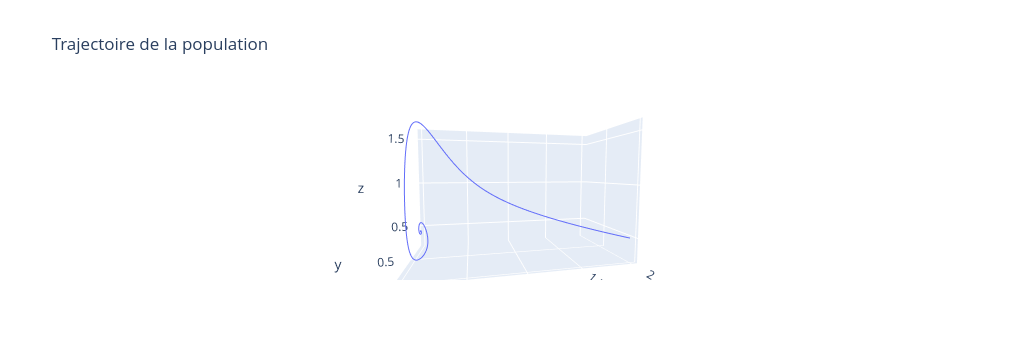

In [7]:
fig = px.line_3d(x=s1[:,0], y=s1[:,1], z=s1[:,2],title="Trajectoire de la population")
fig.show()

### D) Equilibres:

On résout le système suivant : 

$$ 
\left\{\begin{array}{1}
0 = r_xx\left(1-\frac{x}{K_x}\right)+\beta\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)-pxz \\
0 = r_yy\left(1-\frac{y}{K_y}\right)+\beta\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)-pyz \\
0 = z\left(n(x+y) - m\right)
\end{array}\right.
$$

- Si $z^*$=0: 
  On reprend l'analyse de [Arditi et al](https://doi.org/10.1016/j.tpb.2017.12.006) de 2017.
  Ceci donne l'équilibre trivial $(0,0,0)$ (extinction des deux populations) et $(x_1^*,y_1^*,0)$ (disparition des parasites) où $x_1^*$ et $y_1^*$ sont les solutions de l'équilibre en 2) (qu'on peut calculer avec numpy).
- Si $z^*\neq 0$:  
  Il existe un équilibre $(x_2^*,y_2^*,z_2^*)$ (co-existence parasite-ravageur). On va le calculer pour différentes valeurs du taux de migration.

#### **I) Calcul des équilibres :**

On va suivre la méthode de [Freedman et Waltman](https://epubs.siam.org/doi/10.1137/0132052) pour trouver les valeurs des équilibres $(x_2^*,y_2^*,z_2^*)$ pour $\beta$ petit.

##### a) Pour $\beta = 0$ :

Le système (1) devient : 
$$ 
\left\{\begin{array}{1}
0 = r_xx^*_2\left(1-\frac{x^*_2}{K_x}\right)-px^*_2z^*_2\\
0 = r_yy^*_2 \left(1-\frac{y^*_2 }{K_y}\right)-py^*_2 z^*_2 \\
0 = z^*_2\left(n(x^*_2+y^*_2 ) - m\right)
\end{array}\right. \\  
$$

On a ainsi : 
$$
\left\{\begin{array}{1}
x^*_2 =  \frac{K_x\left(r_ym+r_xnK_y-r_ynK_y\right)}{n\left(r_yK_x+r_xK_y\right)}\\
y^*_2 = \frac{K_y\left(r_xm+r_ynK_x-r_xnK_x\right)}{n\left(r_yK_x+r_xK_y\right)}\\
z^*_2 = \frac{r_xr_y\left(nK_x+nK_y-m\right)}{pn\left(r_xK_y+r_yK_x\right)}
\end{array}\right. \\
$$

Il faut que ces équilibres soient positifs, on peut donc en déduire les conditions suivantes sur le système : 
$$-\frac{mr_y}{nK_y}<r_x-r_y<\frac{mr_x}{nK_x}$$
et
$$ K_x+K_y>\frac{m}{n}$$

et si on a égalité de la dernière inégalité on a alors z = 0 et on passe sur l'équilibre $(x_1^*,y_1^*,0)$ avec : 

$$
\left\{\begin{array}{1}
x^*_1 = K_x\\
y^*_1 = K_y\\
z^*_1 = 0
\end{array}\right. \\
$$

qu'on obtient soit en prenant en compte que $K_x = \frac{m}{n} - K_y$ soit en posant z=0 dans (1) et en observant qu'on est face à une croissance logistique.  

Ainsi, si il y a disparition des prédateurs on est dans le même cas que vu en 2) et le système est alors facile a étudier. Si on a pas disparition des prédateurs alors comme on a $x+y=\frac{m}{n}$ et forcément aussi $ K_x+K_y>\frac{m}{n}$ alors donc on a que le système est **mathématiquement déflationiste** quelque soit les autres paramètres. 

###### Preuve mathématique :

$$ 
\left\{\begin{array}{1}
0 = r_xx^*_2\left(1-\frac{x^*_2}{K_x}\right)-px^*_2z^*_2\\
0 = r_yy^*_2 \left(1-\frac{y^*_2 }{K_y}\right)-py^*_2 z^*_2 \\
0 = z^*_2\left(n(x^*_2+y^*_2 ) - m\right)
\end{array}\right. \\  
$$
$$
\Leftrightarrow
$$
$$
\left\{\begin{array}{1}
z^*_2 = \frac{r_x}{p}\left(1-\frac{x^*_2}{K_x}\right) \\
z^*_2 = \frac{r_y}{p}\left(1-\frac{y^*_2 }{K_y}\right) \\
x^*_2+y^*_2  =  \frac{m}{n}
\end{array}\right. \\
$$
$$
\Leftrightarrow
$$
$$
\left\{\begin{array}{1}
0 = rx-\frac{r_xm}{nK_x}+\frac{r_xy^*_2 }{K_x}-ry+\frac{r_yy^*_2 }{K_y} \\
x^*_2 =  \frac{m}{n} - y^*_2 
\end{array}\right. \\
$$
$$
\Leftrightarrow
$$
$$
\left\{\begin{array}{1}
y^*_2  = \left(r_y-r_x+\frac{r_xm}{nK_x}\right)\frac{1}{\left(\frac{r_x}{K_x}+\frac{r_y}{K_y}\right)} \\
x^*_2 =  \frac{m}{n} - y^*_2 
\end{array}\right. \\
$$
$$
\Leftrightarrow
$$
$$
\left\{\begin{array}{1}
y^*_2  = \frac{K_y\left(r_xm+r_ynK_x-r_xnK_x\right)}{n\left(K_x+K_y\right)}\\
x^*_2 =  \frac{m}{n} - y^*_2 
\end{array}\right. \\
$$
$$
\Leftrightarrow
$$
$$
\left\{\begin{array}{1}
y^*_2 = \frac{K_y\left(r_xm+r_ynK_x-r_xnK_x\right)}{n\left(r_yK_x+r_xK_y\right)}\\
x^*_2 =  \frac{K_x\left(r_ym+r_xnK_y-r_ynK_y\right)}{n\left(r_yK_x+r_xK_y\right)}
\end{array}\right. \\
$$
et donc : 
$$
z^*_2 = \frac{r_x}{p}\left(1-\frac{x^*_2}{K_x}\right)
$$
$$
\Leftrightarrow
$$
$$
z^*_2 = \frac{r_xr_y\left(nK_x+nK_y-m\right)}{pn\left(r_xK_y+r_yK_x\right)}
$$

##### b) Pour $\beta > 0$ et petit : 

Pour $\beta$ petit on va utiliser l'égalité de Taylor pour trouver $(x_2^*,y_2^*,z_2^*)$. On a alors si on note $(x_2^*(\beta),y_2^*(\beta),z_2^*(\beta))$:

$$
\left\{\begin{array}{1}
x^*_2(0) =  \frac{K_x\left(r_ym+r_xnK_y-r_ynK_y\right)}{n\left(r_yK_x+r_xK_y\right)}\\
y^*_2(0) = \frac{K_y\left(r_xm+r_ynK_x-r_xnK_x\right)}{n\left(r_yK_x+r_xK_y\right)}\\
z^*_2(0) = \frac{r_xr_y\left(nK_x+nK_y-m\right)}{pn\left(r_xK_y+r_yK_x\right)}
\end{array}\right. \\
$$
et on a les formules suivantes pour calculer les équilibres,
$$
\left\{\begin{array}{1}
x^*_2(\beta) = x^*_2(0) + \frac{\beta K_xK_y\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{1}{x^*_2(0)}+\frac{1}{y^*_2(0)}\right)}{K_yr_x + K_xr_y} + o(\beta)\\
y^*_2(\beta) = y^*_2(0) + \frac{\beta K_xK_y\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{1}{x^*_2(0)}+\frac{1}{y^*_2(0)}\right)}{K_yr_x + K_xr_y} + o(\beta)\\
z^*_2(\beta) = z^*_2(0) + \frac{\beta K_xK_y\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{r_y}{x^*_2(0)K_y}-\frac{r_x}{y^*_2(0)K_x}\right)}{p\left(K_yr_x + K_xr_y\right)} + o(\beta)
\end{array}\right. \\
$$
qu'on peut reécrire : 
$$
\left\{\begin{array}{1}
x^*_2(\beta) = \frac{K_x\left(\beta K_y\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{1}{x^*_2(0)}+\frac{1}{y^*_2(0)}\right)\left(\frac{r_x}{\beta}-\frac{r_y}{\beta}\right)+\frac{r_ym}{n}\right)}{K_yr_x + K_xr_y} + o(\beta)\\
y^*_2(\beta) =\frac{K_y\left(\beta K_x\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{1}{x^*_2(0)}+\frac{1}{y^*_2(0)}\right)\left(\frac{r_y}{\beta}-\frac{r_x}{\beta}\right)+\frac{r_xm}{n}\right)}{K_yr_x + K_xr_y} + o(\beta)\\
z^*_2(\beta) =\frac{r_xr_y\left(K_x+K_y-\frac{m}{n}\right) + \beta K_xK_y\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{r_y}{x^*_2(0)K_y}-\frac{r_x}{y^*_2(0)K_x}\right)}{p\left(K_yr_x + K_xr_y\right)} + o(\beta)
\end{array}\right. \\
$$

###### Preuve mathématique :

Soit $\mathbb{F(x,y,z,\beta)}$ tel que :
$$
\mathbb{F(x,y,z,\beta)} = \left\{\begin{array}{1}
r_xx\left(1-\frac{x}{K_x}\right)+\beta\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)-pxz \\
r_yy\left(1-\frac{y}{K_y}\right)+\beta\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)-pyz \\
z\left(n(x+y) - m\right)
\end{array}\right. \\
$$
On veut ainsi résoudre : 
$$ 
\mathbb{F\left(\mathcal{x}_2^*(\beta) , \mathcal{y}_2^*(\beta) , \mathcal{z}_2^*(\beta) , \beta\right)}=0
$$
or, d'après la formule de Taylor on a à l'ordre 1 en dimension 3 on a : 
$$
\mathbb{F\left(\mathcal{x}_2^*(\beta) , \mathcal{y}_2^*(\beta) , \mathcal{z}_2^*(\beta) , \beta\right)}=\mathbb{F\left(\mathcal{x}_2^*(\mathcal{0}) , \mathcal{y}_2^*(\mathcal{0}) , \mathcal{z}_2^*(\mathcal{0}) , \mathcal{0}\right)} +  \frac{\partial \mathbb{F}}{\partial \beta}\left(\mathcal{x}_2^*(\mathcal{0}) , \mathcal{y}_2^*(\mathcal{0}) , \mathcal{z}_2^*(\mathcal{0}) , \mathcal{0}\right)\beta + \mathbb{J}\tiny{\mathbb{F\left(\mathcal{x}_2^*(\mathcal{0}) , \mathcal{y}_2^*(\mathcal{0}) , \mathcal{z}_2^*(\mathcal{0}) ,\mathcal{0}\right)}}\small\begin{pmatrix} \mathcal{x}_2^*(\beta) - \mathcal{x}_2^*(\mathcal{0}) \\ \mathcal{y}_2^*(\beta) - \mathcal{y}_2^*(\mathcal{0}) \\ \mathcal{z}_2^*(\beta) - \mathcal{z}_2^*(\mathcal{0}) \end{pmatrix} + o(\beta)
$$
$$
\Leftrightarrow$$
$$
\begin{pmatrix} \mathcal{x}_2^*(\beta) \\ \mathcal{y}_2^*(\beta) \\ \mathcal{z}_2^*(\beta) \end{pmatrix} = 
\begin{pmatrix} \mathcal{x}_2^*(\mathcal{0}) \\  \mathcal{y}_2^*(\mathcal{0}) \\  \mathcal{z}_2^*(\mathcal{0}) \end{pmatrix} - \mathbb{J^{\mathcal{-1}}}\tiny{\mathbb{F\left(\mathcal{x}_2^*(\mathcal{0}) , \mathcal{y}_2^*(\mathcal{0}) , \mathcal{z}_2^*(\mathcal{0}) ,\mathcal{0}\right)}} \small\frac{\partial \mathbb{F}}{\partial \beta}\left(\mathcal{x}_2^*(\mathcal{0}) , \mathcal{y}_2^*(\mathcal{0}) , \mathcal{z}_2^*(\mathcal{0}) , \mathcal{0}\right)\beta + o(\beta)
$$
  
On a,  $$\frac{\partial \mathbb{F}}{\partial \beta}\left(\mathcal{x}_2^*(\mathcal{0}) , \mathcal{y}_2^*(\mathcal{0}) , \mathcal{z}_2^*(\mathcal{0}) , \mathcal{0}\right)\beta = \begin{pmatrix} -\frac{\mathcal{x}_2^*(\mathcal{0})}{\gamma_x}+\frac{\mathcal{y}_2^*(\mathcal{0})}{\gamma_y}\\\frac{\mathcal{x}_2^*(\mathcal{0})}{\gamma_x}-\frac{\mathcal{y}_2^*(\mathcal{0})}{\gamma_y}\\ 0\end{pmatrix}$$

et,
$$
\mathbb{J}\small{\mathbb{F\left(\mathcal{x}_2^*(\mathcal{0}) , \mathcal{y}_2^*(\mathcal{0}) , \mathcal{z}_2^*(\mathcal{0}) ,\mathcal{0}\right)}} = 
\begin{pmatrix} -\frac{r_xx_2^*(0)}{K_x} & 0 & -px_2^*(0) \\ 0 & -\frac{r_yy_2^*(0)}{K_y} & -py_2^*(0) \\ nz_2^*(0) & nz_2^*(0) & 0 \end{pmatrix}
$$

il est alors facile de calculer que,
$$ det(\mathbb{J}) = -npx_2^*(0)y_2^*(0)z_2^*(0)\left(\frac{r_x}{K_x}+\frac{r_y}{K_y}\right) \ne 0$$

La jacobienne est donc bien inversible et on peut la calculer (méthode des cofacteurs) ce qui donne : 
$$\mathbb{J^{\mathcal{-1}}}\tiny{\mathbb{F\left(\mathcal{x}_2^*(\mathcal{0}) , \mathcal{y}_2^*(\mathcal{0}) , \mathcal{z}_2^*(\mathcal{0}) ,\mathcal{0}\right)}} =\small \frac{K_xK_y}{K_yr_x+K_xr_y} \begin{pmatrix} -\frac{1}{x_2^*(0)} & \frac{1}{x_2^*(0)} & -\frac{r_y}{y_2^*(0)K_yp} \\ \frac{1}{x_2^*(0)} & -\frac{1}{y_2^*(0)} & \frac{r_x}{z_2^*(0)K_xn} \\ -\frac{r_y}{x_2^*(0)K_yp} & -\frac{r_x}{y_2^*(0)K_xp}& -\frac{r_xr_y}{z_2^*(0)K_xK_ynp} \end{pmatrix}
$$

En mettant en oeuvre le calcul on trouve excatement l'expression donnée.

##### c) Pour $\beta$ quelconque :

**On va calculer la solution sur Python.**
- Lorsque $z \ne 0$ :
(1) donne :
$$ 
\left\{\begin{array}{1}
0 = r_xx\left(1-\frac{x}{K_x}\right)+\beta\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)-pxz \\
0 = r_yy\left(1-\frac{y}{K_y}\right)+\beta\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)-pyz \\
x+y = \frac{m}{n}
\end{array}\right.  $$
et on exprime les deux premières équations en fonction de x ou z :
$$
\left\{\begin{array}{1}
z_1 =  \frac{r_x}{p} -\frac{\beta}{p}\left(\frac{1}{\gamma_x}+\frac{1}{\gamma_y}\right) -\frac{r_xx}{pK_x}+\frac{\beta m}{np\gamma_yx}    \\
z_2 =  \frac{r_y}{p} -\frac{\beta}{p}\left(\frac{1}{\gamma_y}+\frac{1}{\gamma_x}\right) -\frac{r_y(\frac{m}{n}-x)}{pK_y}+\frac{\beta m}{np\gamma_x(\frac{m}{n}-x)} \\
x+y = \frac{m}{n}
\end{array}\right. 
$$

$x_2^*$ et $z_2^*$ correspondent à l'intersection des deux droites $z_1$ et $z_2$. $y_2^*$ est atteint en utilisant la troisième équation du système (2). 

Pour $x^*_2$ : 
On le trouve en résolvant le polynôme suivant : 
$$(r_x - r_y) \left(\frac{m}{n}-x \right)x - x^2 \left(\frac{m}{n}-x \right)\frac{r_x}{K_x} + x \left(\frac{m}{n}-x \right)^2 \frac{r_y}{K_y} + \frac{\beta m}{n} \left( \frac{ \left(\frac{m}{n}-x \right) }{\gamma_y} - \frac{x}{\gamma_x} \right) = 0 $$

Pour $y^*_2$ :
On le retrouve en résolvant le polynôme suivant : 
$$(r_x - r_y) \left(\frac{m}{n}-y \right)y - y^2 \left(\frac{m}{n}-y \right)\frac{r_y}{K_y} + y \left(\frac{m}{n}-y \right)^2 \frac{r_x}{K_x} + \frac{\beta m}{n} \left( \frac{y}{\gamma_y} - \frac{\left(\frac{m}{n}-y \right)}{\gamma_x} \right) = 0 $$

Pour $z^*_2$ : 
$$z^*_2=\frac{r_x}{p} -\frac{\beta}{p}\left(\frac{1}{\gamma_x}+\frac{1}{\gamma_y}\right) -\frac{r_xx_2^*}{pK_x}+\frac{\beta m}{np\gamma_yx_2^*}$$
  
Or, les deux équations pour trouver $x^*_2$ et $y^*_2$ donnent deux solutions positives dont une seule est plus petite que $\frac{m}{n}$.

In [52]:
#Calcul de x*2:
x=np.polynomial.Polynomial([0,1])
#Polynome :
pol1=x*(m1/n1-x)*(rx1-ry1)-(x**2)*(m1/n1-x)*(rx1/Kx1)+x*((m1/n1-x)**2)*(ry1/Ky1)+(b1*(m1/n1))*(((m1/n1-x)/gy1)-(x/gx1))
sol1=pol1.roots()[(np.isreal(pol1.roots())) *(pol1.roots() > 0)*(pol1.roots()<m1/n1)]

#Calcul de y*2:
y=np.polynomial.Polynomial([0,1])
#Polynome :
pol2=(rx1-ry1)*y*(m1/n1-y) - (rx1*((m1/n1-y)**2)/(Kx1))*y+b1*m1/(n1*gy1)*y+(ry1*y/(Ky1))*(m1/n1-y)*y - (b1*m1/(n1*gx1))*(m1/n1-y)
sol2=pol2.roots()[(np.isreal(pol2.roots())) *(pol2.roots() > 0)*(pol2.roots()<m1/n1)]

#Calcul de z*2:
sol3=rx1/p1 - (b1/p1)*(1/gx1+1/gy1) - rx1*sol1/(p1*Kx1) + b1*m1/(n1*p1*gy1*sol1)

Cette animation montre la solution de $x^*_2$ et les solutions imposibles car soit négatives soit plus grande que $\frac{m}{n}$

In [9]:
import IPython.display as display
fig01 = """
<iframe width="1300" height="600" src="https://www.geogebra.org/classic/rvetb5e6" style="border: 1px solid black"></iframe>
"""
display.HTML(fig01)

#### **II) Stabilité des équilibres**

##### a) Pour $z^*_2=0$ :

On va calculer la Jacobienne associée au système : 
$$ 
\mathbb{J_{\mathcal{x},\mathcal{y},\mathcal{z}}}  = \begin{pmatrix} 
\ r_x-\frac{2r_xx}{K_x}-\frac{\beta}{\gamma_x}-pz & \frac{\beta}{\gamma_y} & -px \\
\ \frac{\beta}{\gamma_x} & r_y -\frac{2r_yy}{K_y}-\frac{\beta}{\gamma_y}-pz & -py \\
\ zn & zn & n(x+y)-m
\end{pmatrix}
$$

- $(0,0,0)$ :
$$ 
\mathbb{J_{\mathcal{0},\mathcal{0},\mathcal{0}}}  =  \begin{pmatrix} 
\ r_x-\frac{\beta}{\gamma_x}& \frac{\beta}{\gamma_y} & 0 \\
\ \frac{\beta}{\gamma_x} & r_y-\frac{\beta}{\gamma_y}& 0 \\
\ 0 & 0 &-m
\end{pmatrix}
$$

En calculant la trace et le déterminant on déduit que : 

Si $r_xr_y > \beta\left(\frac{r_x}{\gamma_y}+\frac{r_y}{\gamma_x}\right),  (0,0,0) $ est un point col.  
Si $r_xr_y < \beta\left(\frac{r_x}{\gamma_y}+\frac{r_y}{\gamma_x}\right) $ et $r_x+r_y>\beta\left(\frac{1}{\gamma_y}+\frac{1}{\gamma_x}\right)+m ,  (0,0,0) $ est un point d'équilibre instable.  
Si $r_xr_y < \beta\left(\frac{r_x}{\gamma_y}+\frac{r_y}{\gamma_x}\right) $ et $r_x+r_y<\beta\left(\frac{1}{\gamma_y}+\frac{1}{\gamma_x}\right)+m ,  (0,0,0) $ est un point d'équilibre stable. Ce n'est jamais le cas car la première condition impose la condition d'équilibre instable.

                         
  
- $(x_1^*,y_1^*,0)$ :
$$ 
\mathbb{J_{\mathcal{x_1^*},\mathcal{y_1^*},\mathcal{0}}}  =  \begin{pmatrix} 
\ r_x-\frac{2r_xx_1^*}{K_x}-\frac{\beta}{\gamma_x}& \frac{\beta}{\gamma_y} & -px_1^* \\
\ \frac{\beta}{\gamma_x} & r_y -\frac{2r_yy_1^*}{K_y}-\frac{\beta}{\gamma_y}& -py_1^* \\
\ 0 & 0 & n(x_1^*+y_1^*)-m
\end{pmatrix}
$$

Cet équilibre est stable, on peut le voir graphiquement en [traçant les nullclines](https://doi.org/10.1016/j.tpb.2017.12.006) et le champ de vecteurs associés à ce système. On peut aussi se dire que cet équilibre est le prolongement de l'équilibre stable $(x_2^*,y_2^*,z_2^*)$.

##### b) Pour $z^*_2 \ne 0$ :

###### Si $\beta = 0$ :

$$ 
\mathbb{J_{\mathcal{x^*_2},\mathcal{y^*_2},\mathcal{z^*_2},\mathcal{0}}}  =  \begin{pmatrix} -\frac{r_xx_2^*(0)}{K_x} & 0 & -px_2^*(0) \\ 0 & -\frac{r_yy_2^*(0)}{K_y} & -py_2^*(0) \\ nz_2^*(0) & nz_2^*(0) & 0 \end{pmatrix}
$$
En calculant le polynôme caractéristique on en déduit que toutes les parties réelles des valeurs propres sont négatives et que donc l'équilibre est stable. La preuve est faite par Freedman dans son [théorème 4.1](https://epubs.siam.org/doi/10.1137/0132052).

###### Si $\beta > 0$ et petit:

$$ 
\mathbb{J_{\mathcal{x^*_2},\mathcal{y^*_2},\mathcal{z^*_2},\mathcal{\beta}}}  =  \begin{pmatrix} -\frac{r_xx_2^*(0)}{K_x} -\frac{\beta}{\gamma_x} & \frac{\beta}{\gamma_y} & -px_2^*(0) \\ \frac{\beta}{\gamma_x} & -\frac{r_yy_2^*(0)}{K_y}-\frac{\beta}{\gamma_y} & -py_2^*(0) \\ nz_2^*(0) & nz_2^*(0) & 0 \end{pmatrix} = \mathbb{J_{\mathcal{x^*_2},\mathcal{y^*_2},\mathcal{z^*_2},\mathcal{0}}} + \beta \begin{pmatrix} -\frac{1}{\gamma_x} & \frac{1}{\gamma_y} & 0 \\ \frac{1}{\gamma_x} & -\frac{1}{\gamma_y} & 0 \\ 0 & 0 & 0 \end{pmatrix}
$$

Comme $\beta$ est petit on a la matrice qui est petite et qui n'influence pas le signe des valeurs propres. Donc l'équilibre est encore stable.

### E) Equilibres en fonction de la migration et du taux de fuite: 

#### **I) Equilibre total des ravageurs avec et sans prédateurs:**

Commençons simplement par rappeler que sans prédateurs le système équivaut à celui étudié par Arditi en 2018 et qu'on pouvait obtenir 4 situations différentes pour la somme des équilibres en fonction de $\beta$. Nous noterons : $x^*_1(\beta),y^*_1(\beta)$ l'équilibre du système sans prédateurs tandis qu'on notera $x_2^*(\beta),y^*_2(\beta)$ l'équilibre du système avec prédateurs.  
Il faut comprendre que la condtion pour que les prédateurs s'installent est déterminée par le fait que pour une population de ravageurs à l'équilibre (sans prédateurs) on ait un taux de croissance positif pour les prédateurs.

---

D'abord quand $\beta=0$  on a :  
La condition pour que les prédateurs restent en vie est $K_x+K_y > \frac{m}{n} = x_2^*(0) + y^*_2(0)$ donc le système est constamment déflationiste par rapports aux capacités des deux structures dès que les prédateurs se maintiennent. Quand les prédateurs s'éteignent on a $x_2^*(0) + y^*_2(0) = K_x+K_y$.  


Ensuite, dans le cas général ($\beta \ne 0$), on a, sans prédateurs, qu'on tend vers $x_2^*(\beta)=x^*_1(\beta), y^*_2(\beta)=y^*_1(\beta)$. Pour avoir des prédateurs, et donc en supposant $z \ne 0$ (il y a une infime population de prédateurs), on veut que $n(x^*_1(\beta)+y^*_1(\beta)) - m > 0$ pour avoir un taux de croissance positif.  

Ainsi, la condition pour que la population de prédateurs s'installent, et qu'on puisse donc considérer $x_2^*(\beta),y^*_2(\beta)$ est différent de $x^*_1(\beta),y^*_1(\beta)$, a changé et est maintenant : 
$x^*_1(\beta)+y^*_1(\beta) > \frac{m}{n}$. Une fois les prédateurs installés on a forcément que $x_2^*(\beta)+y^*_2(\beta)=\frac{m}{n}$.  
On a donc possibilité que le système subisse une inflation même en présence de prédateurs contrairement à ce qu'on a vu quand $\beta=0$.   
  
---

Pour exprimer les inflations et déflations on va donc reprendre les graphiques en 2) :

Text(0.5, 1.0, 'Déflation')

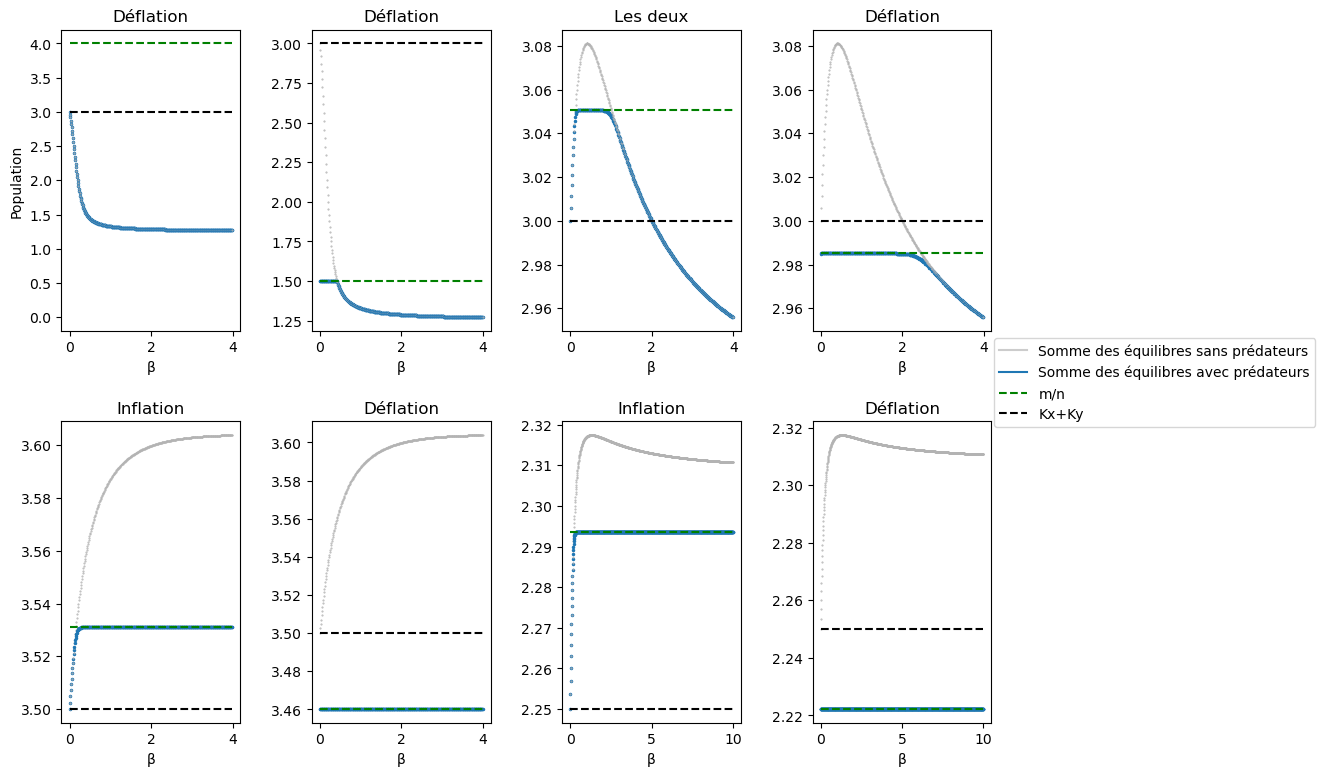

In [19]:
#Définition d'une fonction qui prend en compte le changement de migration:
def a(etat,t,param,i):
    x,y,z=etat
    b=i
    rx,Kx,ry,Ky,gx,gy,p,n,m = param
    xdot,ydot,zdot=[rx*x*(1-x/Kx)+b*(y/gy-x/gx)-p*z*x,ry*y*(1-y/Ky)+b*(x/gx-y/gy)-p*y*z,z*(n*(x+y)-m)]
    return [xdot,ydot,zdot]

#Définition du modèle sans prédateurs:
def aug(etat,t,param,i):
    rx,Kx,ry,Ky,gx,gy=param
    b=i
    x,y=etat
    s=[rx*x*(1-x/Kx)+b*(y/gy-x/gx),ry*y*(1-y/Ky)+b*(x/gx-y/gy)]
    return s 

#Définition des paramètres:
#1:
rx1 = 0.5
ry1 = 1
Kx1 = 2
Ky1 = 1
gx1 = 0.5
gy1 = 3
p1=1
m11=1
n11=0.25
m12=3
n12=2

param11=np.array([rx1,Kx1,ry1,Ky1,gx1,gy1,p1,n11,m11])
param12=np.array([rx1,Kx1,ry1,Ky1,gx1,gy1,p1,n12,m12])

#2:
rx2 = 0.5
ry2 = 1
Kx2 = 2
Ky2 = 1
gx2 = 5
gy2 = 1
p2=1
m21=1
n21=0.3278
m22=1
n22=0.335

param21=np.array([rx2,Kx2,ry2,Ky2,gx2,gy2,p2,n21,m21])
param22=np.array([rx2,Kx2,ry2,Ky2,gx2,gy2,p2,n22,m22])

#3:
rx3 = 1
ry3 = 2
Kx3 = 2
Ky3 = 1.5
gx3 = 2
gy3 = 1
p3=0.5
m31=1
n31=0.2832
m32=1
n32=0.289

param31=np.array([rx3,Kx3,ry3,Ky3,gx3,gy3,p3,n31,m31])
param32=np.array([rx3,Kx3,ry3,Ky3,gx3,gy3,p3,n32,m32])

#4:
rx4 = 2
ry4 = 1
Kx4 = 1
Ky4 = 1.25
gx4 = 0.5
gy4 = 1
p4=1
m41=1
n41=0.436
m42=1
n42=0.45

param41=np.array([rx4,Kx4,ry4,Ky4,gx4,gy4,p4,n41,m41])
param42=np.array([rx4,Kx4,ry4,Ky4,gx4,gy4,p4,n42,m42])

#Temps d'intégration suffisament large pour atteindre l'équilibre:
t=np.arange(0,1000,0.01)

#Condition initiale:
e0=[1,1,1]

#Figure:
fig,ax=plt.subplots(2,4,figsize=(12,9))
plt.subplots_adjust(wspace=0.4,hspace=0.3)


#Boucle pour plot en fonction de beta:
for i in np.arange(0,4,0.01):
    s11=odeint(a,e0,t,args=(param11,i)) #On calcule pour chaque beta l'équilibre
    ax[0][0].plot(i,s11[-1][0]+s11[-1][1],marker='.',markersize=3,color='C0')
    s12=odeint(a,e0,t,args=(param12,i))
    ax[0][1].plot(i,s12[-1][0]+s12[-1][1],marker='.',markersize=3,color='C0')
    
    s11sp=odeint(aug,e0[0:2],t,args=(param11[0:6],i))
    ax[0][0].plot(i,s11sp[-1][0]+s11sp[-1][1],marker='.',markersize=1,color='0.7')
    s12sp=odeint(aug,e0[0:2],t,args=(param12[0:6],i))
    ax[0][1].plot(i,s12sp[-1][0]+s12sp[-1][1],marker='.',markersize=1,color='0.7')
    
    
    s21=odeint(a,e0,t,args=(param21,i))
    ax[0][2].plot(i,s21[-1][0]+s21[-1][1],marker='.',markersize=3,color='C0')             
    s22=odeint(a,e0,t,args=(param22,i))
    ax[0][3].plot(i,s22[-1][0]+s22[-1][1],marker='.',markersize=3,color='C0')              
    
    s21sp=odeint(aug,e0[0:2],t,args=(param21[0:6],i))
    ax[0][2].plot(i,s21sp[-1][0]+s21sp[-1][1],marker='.',markersize=1,color='0.7')
    s22sp=odeint(aug,e0[0:2],t,args=(param22[0:6],i))
    ax[0][3].plot(i,s22sp[-1][0]+s22sp[-1][1],marker='.',markersize=1,color='0.7')
    
    
    s31=odeint(a,e0,t,args=(param31,i))
    ax[1][0].plot(i,s31[-1][0]+s31[-1][1],marker='.',markersize=3,color='C0')
    s32=odeint(a,e0,t,args=(param32,i))
    ax[1][1].plot(i,s32[-1][0]+s32[-1][1],marker='.',markersize=3,color='C0')
    
    s31sp=odeint(aug,e0[0:2],t,args=(param31[0:6],i))
    ax[1][0].plot(i,s31sp[-1][0]+s31sp[-1][1],marker='.',markersize=1,color='0.7')
    s32sp=odeint(aug,e0[0:2],t,args=(param32[0:6],i))
    ax[1][1].plot(i,s32sp[-1][0]+s32sp[-1][1],marker='.',markersize=1,color='0.7')
    
for i in np.arange(0,10,0.01):
    s41=odeint(a,e0,t,args=(param41,i))
    ax[1][2].plot(i,s41[-1][0]+s41[-1][1],marker='.',markersize=3,color='C0')
    s42=odeint(a,e0,t,args=(param42,i))
    ax[1][3].plot(i,s42[-1][0]+s42[-1][1],marker='.',markersize=3,color='C0')
    
    s41sp=odeint(aug,e0[0:2],t,args=(param41[0:6],i))
    ax[1][2].plot(i,s41sp[-1][0]+s41sp[-1][1],marker='.',markersize=1,color='0.7')
    s42sp=odeint(aug,e0[0:2],t,args=(param42[0:6],i))
    ax[1][3].plot(i,s42sp[-1][0]+s42sp[-1][1],marker='.',markersize=1,color='0.7')

#Plot de la droite Kx+Ky:    
xt=np.arange(0,4,0.01)
xt2=np.arange(0,4,0.01)
xt3=np.arange(0,10,0.01)

ax[0][0].plot(xt,(Kx1+Ky1)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[0][1].plot(xt2,(Kx1+Ky1)*np.ones_like(xt2),linestyle='dashed',color='k',markersize='6')
ax[0][2].plot(xt,(Kx2+Ky2)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[0][3].plot(xt,(Kx2+Ky2)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[1][0].plot(xt2,(Kx3+Ky3)*np.ones_like(xt2),linestyle='dashed',color='k',markersize='6')
ax[1][1].plot(xt,(Kx3+Ky3)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[1][2].plot(xt3,(Kx4+Ky4)*np.ones_like(xt3),linestyle='dashed',color='k',markersize='6')
ax[1][3].plot(xt3,(Kx4+Ky4)*np.ones_like(xt3),linestyle='dashed',color='k',markersize='6')

#Plot de m/n:
ax[0][0].plot(xt,m11/n11*np.ones_like(xt),linestyle='dashed',color='g',markersize='6')
ax[0][1].plot(xt,m12/n12*np.ones_like(xt),linestyle='dashed',color='g',markersize='6')
ax[0][2].plot(xt,m21/n21*np.ones_like(xt),linestyle='dashed',color='g',markersize='6')
ax[0][3].plot(xt,m22/n22*np.ones_like(xt),linestyle='dashed',color='g',markersize='6')
ax[1][0].plot(xt,m31/n31*np.ones_like(xt),linestyle='dashed',color='g',markersize='6')
ax[1][1].plot(xt,m32/n32*np.ones_like(xt),linestyle='dashed',color='g',markersize='6')         
ax[1][2].plot(xt3,m41/n41*np.ones_like(xt3),linestyle='dashed',color='g',markersize='6')
ax[1][3].plot(xt3,m42/n42*np.ones_like(xt3),linestyle='dashed',color='g',markersize='6')  

#Légendes:
ax[0][0].set_xlabel('β')
ax[0][1].set_xlabel('β')
ax[0][2].set_xlabel('β')
ax[0][3].set_xlabel('β')
ax[1][0].set_xlabel('β')
ax[1][1].set_xlabel('β')
ax[1][2].set_xlabel('β')
ax[1][3].set_xlabel('β')

ax[0][0].set_ylabel('Population')
ax[0][0].plot(0,0,color='0.8',label='Somme des équilibres sans prédateurs')
ax[0][0].plot(0,0,color='C0',label='Somme des équilibres avec prédateurs')
ax[0][0].plot(0,0,linestyle='dashed',color='g',markersize='6',label='m/n')
ax[0][0].plot(0,0,linestyle='dashed',color='k',markersize='6',label='Kx+Ky')

#On déplace la légende hors de la figure:
ax[0][0].legend(bbox_to_anchor=(6.55, -0.5, 0.5, 0.5),fontsize=10)

#Titres:
ax[0][0].set_title('Déflation')
ax[0][1].set_title('Déflation')
ax[0][2].set_title('Les deux')
ax[0][3].set_title('Déflation')
ax[1][0].set_title('Inflation')
ax[1][1].set_title('Déflation')
ax[1][2].set_title('Inflation')
ax[1][3].set_title('Déflation')

Dans ces simulations on a posé les 4 situations possibles de courbes comme en 2) avec, soit $\frac{m}{n}$ plus grand que la somme des capacités soit $\frac{m}{n}$ plus petits que la somme des capacités. On se retrouve donc avec 8 profils différents. *On aurait pu inclure les profils où $\frac{m}{n}$ est complètement au dessus ou en dessous mais ils n'avaient pas grand intérêt.*  

Lorsque les prédateurs sont présents, ie que $x^*_1(\beta)+y^*_1(\beta)>\frac{m}{n}$, c'est à dire quand la courbe grise est au dessus de la droite verte on a bien que 
$x_2^*(\beta)+y^*_2(\beta)=\frac{m}{n}$. Quand ils sont absents (la courbe grise est en dessous de la droite verte) on observe bien que $x_2^*(\beta)=x^*_1(\beta), y^*_2(\beta)=y^*_1(\beta)$ (les courbes bleu et grise sont confondues).

On observe que lorsqu'on a $\frac{m}{n} < K_x + K_y $ on a toujours un système déflationiste, en effet on a alors que soit le système sans prédateurs avait une somme au dessus de $\frac{m}{n}$ et on ainsi que l'équilibre vaut $\frac{m}{n}$ (qui est par l'observation sous $K_x + K_y $ et donc déflation) soit le système était en dessous de $\frac{m}{n}$ et donc on a la somme correspondant à l'équilibre sans prédateurs mais qui est en dessous de $K_x + K_y$ par observation.

Ces graphiques traduisent bien l'effet de l'ajout des prédateurs dans un système : si celui ci est déja déflationiste il le reste, si celui ci était inflationiste et déflationiste ou complètement inflationiste il peut devenir déflationiste.   

---

Enfin on voit à travers ces graphiques que l'ajout des prédateurs modifie le système mais les courbes sont quand même souvent confondues. Il est donc plausible qu'il y ait une condition sur les taux de fuite comme en 2) qui peut s'appliquer au 3) (Voir F)).

---

On voit que la condition d'équilibre $z \ne 0$ impose que la somme de la population de ravageur est égale, à l'équilibre, à $\frac{m}{n}$.  
Ceci est crucial car alors si $m<n$ on a $\frac{m}{n} < 1$ et comme les capacités biotiques sont à priori plus grande que m ou n on a que le système est très déflationiste. Le taux de naissance et de mortalité des parasites est donc crucial pour ce modèle !  
Il faut donc dans la situation de l'augmentorium tout faire pour rendre bénéfique la croissance des parasites (arrêt des pesticides, élimination des prédateurs des prédateurs ?).  

Enfaite, on obtient la même chose que la moyenne des proies dans un modèle de Lotka-Volterra, ceci paraît assez logique, car notre modèle est basé dessus. 
Le lien n'a néanmoins pas été fait par Freedman et Waltman (ou alors c'est tellement logique que personne n'en parle).   

#### **II) Equilibre des ravageurs dans la culture:**

On va maintenant voir l'évolution de l'équilibre dans la culture en fonction de $\gamma_x$ (le taux de migration) et de $\gamma_y$ (le taux de fuite):

Text(4.75, 0.9, '$K_x$')

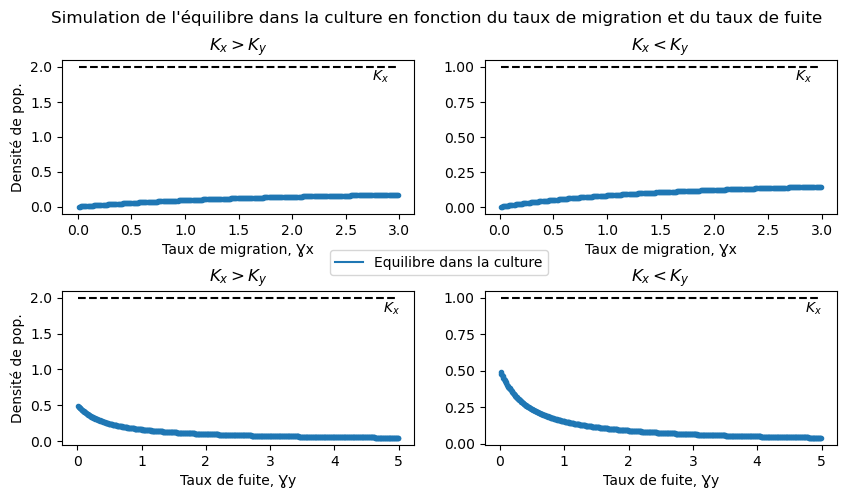

In [10]:
#On définit un modèle qui prend en compte le changement de b et un autre qui prend en compte le changement de gy
def a1(etat,t,param,h):
    x,y,z=etat
    rx,Kx,ry,Ky,b,gy,p,n,m = param
    gx=h
    xdot,ydot,zdot=[rx*x*(1-x/Kx)+b*(y/gy-x/gx)-p*z*x,ry*y*(1-y/Ky)+b*(x/gx-y/gy)-p*y*z,z*(n*(x+y)-m)]
    return xdot,ydot,zdot

def a2(etat,t,param,h):
    x,y,z=etat
    rx,Kx,ry,Ky,gx,b,p,n,m = param
    gy=h
    xdot,ydot,zdot=[rx*x*(1-x/Kx)+b*(y/gy-x/gx)-p*z*x,ry*y*(1-y/Ky)+b*(x/gx-y/gy)-p*y*z,z*(n*(x+y)-m)]
    return xdot,ydot,zdot

#Paramètres Simulation b1: 
rx1=0.5
ry1=1
Kx1=2
Ky1=1
b1=1
gy1=4
p1=1
n1=1
m1=0.5

param_a1=np.array([rx1,Kx1,ry1,Ky1,b1,gy1,p1,n1,m1])

#Paramètres Simulation b2: 
rx2=0.5
ry2=1
Kx2=1
Ky2=2
b2=1
gy2=4
p2=1
n2=1
m2=0.5

param_a2=np.array([rx2,Kx2,ry2,Ky2,b2,gy2,p2,n2,m2])

#Paramètres Simulation gy1: 
rx3=0.5
ry3=1
Kx3=2
Ky3=1
gx3=0.5
b3=1
p3=1
n3=1
m3=0.5

param_a3=np.array([rx3,Kx3,ry3,Ky3,gx3,b3,p3,n3,m3])

#Paramètres Simulation gy2: 
rx4=0.5
ry4=1
Kx4=1
Ky4=2
gx4=0.5
b4=1
p4=1
n4=1
m4=0.5

param_a4=np.array([rx4,Kx4,ry4,Ky4,gx4,b4,p4,n4,m4])

#Temps d'intégration:
t1=np.arange(0,500,0.01)

#Conditions initiales:
x0=1
y0=1
z0=1
c0=np.array([x0,y0,z0])

#On trace la figure:
fig1,ax=plt.subplots(2,2,figsize=(10,5))

#Boucle qui met à jour b et simule à chaque fois l'équilibre :
for i in np.arange(0.01,3,0.01):
    sa1=odeint(a1,c0,t1,args=(param_a1,i))
    ax[0][0].plot(i,sa1[-1][0],marker='.',color='C0')
    sa2=odeint(a1,c0,t1,args=(param_a2,i))
    ax[0][1].plot(i,sa2[-1][0],marker='.',color='C0')

#Boucle qui met à jour gy et simule l'équilibre:
for i in np.arange(0.01,5,0.01):
    sa3=odeint(a2,c0,t1,args=(param_a3,i))
    ax[1][0].plot(i,sa3[-1][0],marker='.',color='C0')
    sa4=odeint(a2,c0,t1,args=(param_a4,i))
    ax[1][1].plot(i,sa4[-1][0],marker='.',color='C0')

#On plot la ligne correspondant à Kx
xt=np.arange(0.01,3,0.01)
xt2=np.arange(0.01,5,0.01)
ax[0][0].plot(xt,Kx1*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[0][1].plot(xt,Kx2*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[1][0].plot(xt2,Kx3*np.ones_like(xt2),linestyle='dashed',color='k',markersize='6')
ax[1][1].plot(xt2,Kx4*np.ones_like(xt2),linestyle='dashed',color='k',markersize='6')

##Légendes et titres:
fig1.suptitle("Simulation de l\'équilibre dans la culture en fonction du taux de migration et du taux de fuite")

#Abssices:
ax[0][0].set_xlabel("Taux de migration, Ɣx")
ax[0][1].set_xlabel("Taux de migration, Ɣx")
ax[1][0].set_xlabel("Taux de fuite, Ɣy")
ax[1][1].set_xlabel("Taux de fuite, Ɣy")

#Titre des sous figures:
ax[0][0].set_title("$K_x>K_y$")
ax[0][1].set_title("$K_x<K_y$")
ax[1][0].set_title("$K_x>K_y$")
ax[1][1].set_title("$K_x<K_y$")

#Ordonnées:
ax[0][0].set_ylabel("Densité de pop.")
ax[1][0].set_ylabel("Densité de pop.")

#Légende générale:
ax[0][0].plot(0,0,color='C0',label='Equilibre dans la culture')

#On déplace la légende hors de la figure:
ax[0][0].legend(bbox_to_anchor=(0.9, -0.69, 0.5, 0.5))

#Ecartement des figures:
plt.subplots_adjust(hspace=0.5)

#Texte Kx:
ax[0][0].text(2.75,Kx1-0.2,'$K_x$')
ax[0][1].text(2.75,Kx2-0.1,'$K_x$')
ax[1][0].text(4.75,Kx3-0.2,'$K_x$')
ax[1][1].text(4.75,Kx4-0.1,'$K_x$')

En haut on observe l'équilibre en fonction du **taux de migration**. On voit que quelque soit la culture on a un équilibre qui est bien en dessous de la capactié biotique de la culture. La technique de l'augmentorium semble être efficace.  
On observe que quand le taux de migration est fort ($\gamma_x$ petit) alors on a un équilibre dans la culture faible et celui augmente au fur et à mesure que le taux de migration ralentit. Mettre de l'effort dans la tache de ramasser les fruits et les séquestrer n'est donc pas vain.  

Maintenant quand on regarde le **taux de fuite**, s'il est élevé (valeur petite de $\gamma_y$) alors on a un équilibre dans la culture plus grand que si il est faible. Plus $\gamma_y$ est grand (et donc plus le taux de fuite est faible) moins l'équilibre dans la culture est élevé.  
Ce paramètre est donc crucial et c'est quelque chose qu'il faut continuer d'améliorer (en mettant en place des sas, de la lumière à l'opposé de l'entrée pour attirer les ravageurs etc.). 

### F) Conditions pour avoir déflation du système avec prédateur:

*Cette analyse se base sur les graphiques obtenus en 3.E.I).*   
On a vu que si le système sans prédateurs est de base déflationiste alors le système avec prédateurs est aussi déflationiste (avec survie ou pas des prédateurs).  
Ainsi d'après 2.B) on a que si $\frac{\gamma_y}{\gamma_x}>\frac{K_y}{K_x}$ alors le système avec prédateurs est toujours déflationiste.  

De plus, si $\frac{\gamma_y}{\gamma_x}<\frac{K_y}{K_x}$ alors on a soit un système inflationiste si $\frac{m}{n} < K_x+K_y$ soit un système inflationiste et déflationiste mais moins inflationiste quand sans les prédateurs si $\frac{m}{n} < (x^*+y^*)_{max}$.  
  
Enfin si $\frac{r_xK_y}{r_yK_x} < \frac{\gamma_y}{\gamma_x} < \frac{K_y}{K_x}$ alors si on a $x^*(\infty)+y^*(\infty) > \frac{m}{n} > K_x+K_y$ alors le système est inflationiste mais moins que son pendant sans prédateurs du 2).

### G) Conclusion:

La technique de l'augmentorium semble encore une fois bénéfique quelque soit la culture en imposant que la naissance et la prédation est la même entre les deux structures.
Mais, biologiquement parlant, le fait de considérer que les naissances et la prédation sont égales entre l'augmentorium et la culture n'a pas vraiment de sens.   
On va ainsi considérer en 4) le modèle posé par Freedman et Waltman en 77.

## 4) **Modèle complet de l'augmentorium :**

### A) Définition du modèle:

En 3) avec les simplifications apportées au modèle on s'était retrouvé avec une condition sur la somme de l'équilibre. Mais les simplifications ne rendent pas assez compte de la réalité et il est intéressant de voir comment se comporte le système dans un cas plus général.    

*Pour cela on reprend le modèle posé par [Freedman](http://dx.doi.org/10.1137/0132052) et on l'adapte aux conditions de l'augmentorium.*   

Voici le modèle que l'on pose:  
  
  
$$ \left\{\begin{array}{1}
\dot x = r_xx\left(1-\frac{x}{K_x}\right)+\beta\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)-p_xxz \\
\dot y = r_yy\left(1-\frac{y}{K_y}\right)+\beta\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)-p_yyz \\
\dot z = z\left(n_xx+n_yy - m\right)
\end{array}\right.
$$

avec:  
- $r_x$ le taux de croissance de x dans la culture,  
- $r_y$ le taux de croissance de y dans l'augmentorium,  
- $K_x$ la capacité maximale de la culture,  
- $K_y$ la capacité maximale de l'augmentorium,  
- $\beta$ la force de migration,  
- $\gamma_x$ le taux d'assymétrie de la migration culture vers augmentorium,  
- $\gamma_y$ le taux d'assymétrie de la migration augmentorium vers culture,  
- $p_x,p_y$ la prédation de $z$ sur $x$ ou $y$,
- $n_x,n_y$ le taux de conversion proie prédateur dans la culture ou l'augmentorium (naissance due à la prédation),  
- $m$ la mortalité des prédateurs $z$.  
  
On a donc maintenant un espace structuré en deux zones, s'échangeant assymétriquement de la population (qui grandit logisitiquement), le tout controlé par une population de prédateurs ne chassant et ne se reproduisant pas de la même manière dans les deux zones.  

**Hypothèses**:

Dans le cas de l'augmentorium la tente est la limite, le fait de forcer une migration de ravageurs dans celui ci en confinant les fruits pourris cause l'assymétrie. Il y a donc un $\gamma_x << \gamma_y$.  
De même en reprenant les hypothèses en 3) on a $r_x<r_y$.  

On peut biologiquement imaginer que les parasites aux ravageurs (qu'on appellerra prédateurs) ont un meilleur taux de prédation dans l'augmentorium et que donc $p_y > p_x$ et ensuite on imagine que du fait qu'il y ait plus de prédation et que l'augmentorium soit protégé des pesticides les naissances dans celui-ci sont plus forte que dans la culture ie $n_y>n_x$.  
Encore une fois en fonction du type de culture on pourra obtenir une condition sur les capacités biotiques.

### B) Dynamique:

Text(0.5, 1.0, 'Disparition des parasites, maintien des ravageurs')

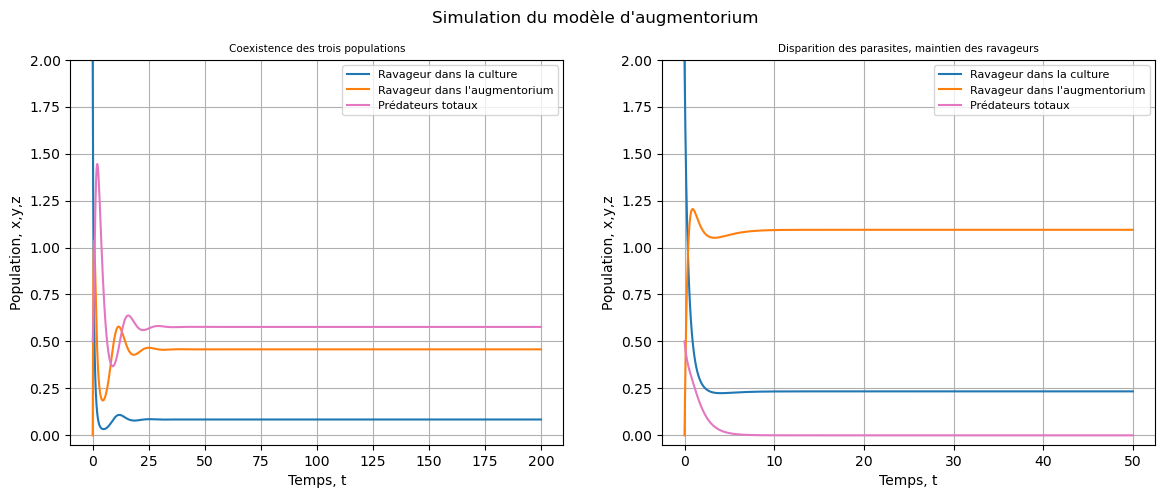

In [59]:
#Définition du modèle avec prédateurs:
def a(etat,t,param):
    x,y,z=etat
    rx,Kx,ry,Ky,gx,gy,b,px,py,nx,ny,m = param
    xdot,ydot,zdot=[rx*x*(1-x/Kx)+b*(y/gy-x/gx)-px*z*x,ry*y*(1-y/Ky)+b*(x/gx-y/gy)-py*y*z,z*(nx*x+ny*y-m)]
    return [xdot,ydot,zdot]

#Paramètres Simulation 1 : 
rx1=0.5
ry1=1
Kx1=2
Ky1=1
gx1=0.5
gy1=3
b1=1
px1=0.5
py1=1
nx1=0.5
ny1=1
m1=0.5

param_a1=np.array([rx1,Kx1,ry1,Ky1,gx1,gy1,b1,px1,py1,nx1,ny1,m1])

#Paramètres Simulation 2: 
rx2=0.5
ry2=1
Kx2=2
Ky2=1
gx2=0.5
gy2=3
b2=1
px2=0.5
py2=1
nx2=0.5
ny2=1
m2=2

param_a2=np.array([rx2,Kx2,ry2,Ky2,gx2,gy2,b2,px2,py2,nx2,ny2,m2])

#Temps d'intégration 1,2:
t3=np.arange(0,200,0.01)
t4=np.arange(0,50,0.01)

#Condition initiale de 1,2:
x0=2
y0=0
z0=0.5
c0=np.array([x0,y0,z0])

#Simulation 1,2:
s3=odeint(a,c0,t3,args=(param_a1,))
s4=odeint(a,c0,t4,args=(param_a2,))

#Plot de la figure: 
fig,ax = plt.subplots(1,2,figsize=(14,5))
fig.suptitle('Simulation du modèle d\'augmentorium')
plt.subplots_adjust(hspace=0.4)

#Plot de l'axe 1:
ax[0].plot(t3,s3[:,0],color='C0',label='Ravageur dans la culture')
ax[0].plot(t3,s3[:,1],color='C1',label='Ravageur dans l\'augmentorium')
ax[0].plot(t3,s3[:,2],color='C6',label='Prédateurs totaux')

#Plot de l'axe 2:
ax[1].plot(t4,s4[:,0],color='C0',label='Ravageur dans la culture')
ax[1].plot(t4,s4[:,1],color='C1',label='Ravageur dans l\'augmentorium')
ax[1].plot(t4,s4[:,2],color='C6',label='Prédateurs totaux')


#Légendes et titres:
ax[0].set_ylabel('Population, x,y,z')
ax[0].legend(fontsize=8)
ax[0].grid()
ax[0].set_xlabel('Temps, t')
ax[0].set_ylim(top=2,bottom=-0.05)
ax[0].set_title('Coexistence des trois populations',fontsize=7.5)

ax[1].set_xlabel('Temps, t')
ax[1].set_ylabel('Population, x,y,z')
ax[1].legend(fontsize=8)
ax[1].grid()
ax[1].set_ylim(top=2,bottom=-0.05)

ax[1].set_title('Disparition des parasites, maintien des ravageurs',fontsize=7.5)

On observe que les profils de dynamique sont similaires à ceux observés en 3). En jouant sur le taux de mortalité des prédateurs (à droite moins de mortalité qu'à gauche) on observe que deux équilibres (qui semblent stables) peuvent êtres atteints. L'un avec maintien des prédateurs l'autre avec extinction des prédateurs. 
Encore une fois, la dynamique sans prédateurs correspond au système étudié en 2), nous n'analyserons donc pas en profondeur cette condition.  
Nous allons justifier qu'il n'y a qu'un seul équilibre atteignable avec maintien des prédateurs grâce au plan de phase.

### C) Plan de phase:

Pour tracer le plan de phase on pose toutes les variations égales à $0$ (situation d'équilibre) :   

$$
\left\{\begin{array}{1}
0 = r_xx\left(1-\frac{x}{K_x}\right)+\beta\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)-p_xxz \\
0 = r_yy\left(1-\frac{y}{K_y}\right)+\beta\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)-p_yyz \\
0 = z\left(n_xx+n_yy - m\right)
\end{array}\right.
$$
qui devient :  
$$
\left\{\begin{array}{1}
z_1 = \frac{r_x}{p_x}\left(1-\frac{x}{K_x}\right)+\frac{\beta}{p_xx}\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)\\
z_2 = \frac{r_y}{p_y}\left(1-\frac{y}{K_y}\right)+\frac{\beta}{p_yy}\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)\\
z=0 \lor n_xx+n_yy=m
\end{array}\right.
$$  
On se retrouve avec deux surfaces et deux plans dont les intersections seront les équilibres. Voyons ceci avec une animation :  

In [8]:
import IPython.display as display
fig01 = """
<iframe width="1300" height="600" src="https://www.geogebra.org/classic/bw3wqnzg" style="border: 1px solid black"></iframe>
"""
display.HTML(fig01)

Sur cette animation on observe trois croisements et donc on a 3 équilibres pour ce système. Les deux équilibres non nuls ont l'air d'être stable selon le plan de phase.  
La trajectoire de la population est représenté ci dessous pour les conditions initiales $x_0=2,y_0=0,z_0=0.5$ :

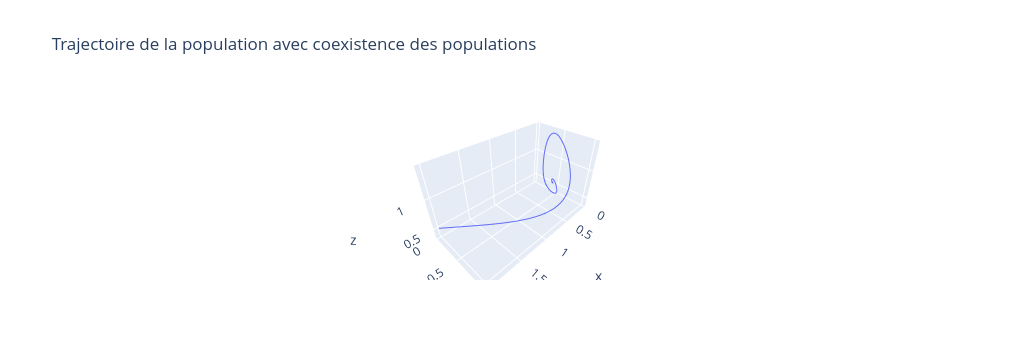

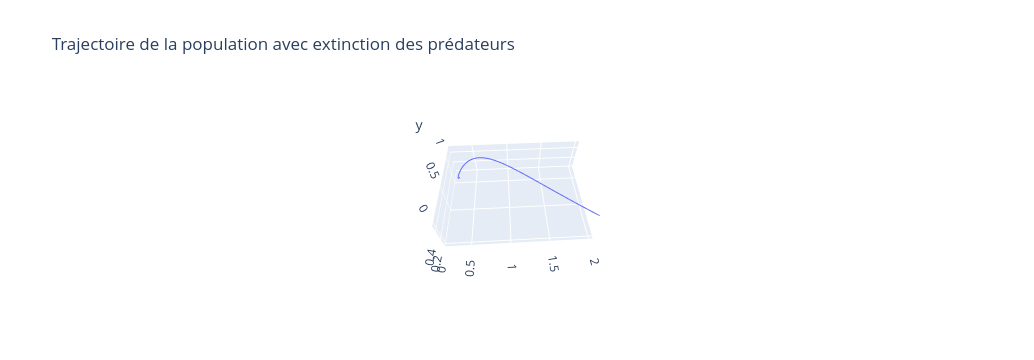

In [13]:
fig = px.line_3d(x=s3[:,0], y=s3[:,1], z=s3[:,2],title="Trajectoire de la population avec coexistence des populations")
fig2 = px.line_3d(x=s4[:,0], y=s4[:,1], z=s4[:,2],title="Trajectoire de la population avec extinction des prédateurs")
fig.show()
fig2.show()

### D) Equilibres :

Dans cette partie on va suivre le même raisonnement qu'en 3) et on va suivre la méthode utilisée par Freedman et Waltman pour calculer l'équilibre de coexistence qui consite à analyser le système pour différentes valeurs de $\beta$, ie $\beta =0$ puis $\beta$ petit (en utilisant Taylor en dim 4) et enfin le cas $\beta$ quelconque sera fait par simulation en résolvant directement le système grâce à numpy de Python.  
  
On résout le système suivant : 

$$ 
\left\{\begin{array}{1}
0 = r_xx\left(1-\frac{x}{K_x}\right)+\beta\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)-p_xxz \\
0 = r_yy\left(1-\frac{y}{K_y}\right)+\beta\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)-p_yyz \\
0 = z\left(n_xx+n_yy - m\right)
\end{array}\right.
$$

- Si $z^*$=0: 
  On reprend l'analyse de [Arditi et al](https://doi.org/10.1016/j.tpb.2017.12.006) de 2017.
  Ceci donne l'équilibre trivial $(0,0,0)$ (extinction des deux populations) et $(x_1^*,y_1^*,0)$ (disparition des parasites) où $x_1^*$ et $y_1^*$ sont les solutions de l'équilibre en 2) (qu'on peut calculer avec numpy).
- Si $z^*\neq 0$:  
  Il existe un équilibre $(x_2^*,y_2^*,z_2^*)$ (co-existence parasite-ravageur). On va le calculer pour différentes valeurs du taux de migration.

#### I) Calcul de l'équilibre $(x_2^*,y_2^*,z_2^*)$ :

##### a) Pour $\beta =0$ 

Le système (1) devient :  
$$ 
\left\{\begin{array}{1}
0 = r_xx^*_2\left(1-\frac{x^*_2}{K_x}\right)-p_xx^*_2z^*_2\\
0 = r_yy^*_2 \left(1-\frac{y^*_2 }{K_y}\right)-p_yy^*_2 z^*_2 \\
0 = z^*_2\left(n_xx^*_2+n_yy^*_2 - m\right)
\end{array}\right. \\  
$$  
et on a ainsi:

$$
\left\{\begin{array}{1}
x^*_2 =  \frac{K_x\left(r_yp_xm+r_xn_yp_yK_y-r_yn_yp_xK_y\right)}{r_xn_yp_yK_y+r_yn_xp_xK_x}\\
y^*_2 = \frac{K_y\left(r_yn_xp_xK_x+r_xp_ym - r_xn_xp_yK_x\right)}{r_xn_yp_yK_y+r_yn_xp_xK_x}\\
z^*_2 = r_xr_y\left(\frac{n_xK_x+n_yK_y-m}{r_xn_yp_yK_y+r_yn_xp_xK_x}\right)
\end{array}\right. \\
$$

⚠️ : Le document de Freedman contient deux erreurs, un $B_1$ à la place d'un $\beta_1$ dans l'expression de $y_2^*$ (respectivement $x_20$ dans son article) et un $p_y$ à la place d'un $p_x$ dans l'expression de $z^*_2$ (respectivement un $\beta_2$ à la place d'un $\beta_1$ selon ses notations).
  
Pour que ces équilibres soient positifs il faut que :  

$$ -\frac{mr_y}{K_yn_yp_y} < \frac{r_x}{p_x} - \frac{r_y}{p_y} < \frac{mr_x}{K_xn_xp_x} $$  

et

$$ n_xK_x+n_yK_y > m $$
  
On a, si les prédateurs se maintiennent, que $n_xK_x + n_yK_y > m$ et on a aussi que $n_xx^*_2+n_yy^*_2 = m$  ainsi on a $n_xK_x + n_yK_y > n_xx^*_2+n_yy^*_2$.   
Cette condition est tout le temps vérifiée dans le système dès qu'on a pas disparition des prédateurs. Contrairement à la partie 3) on a pas forcément un système déflationiste quand les parasites se maintiennent.   

*La preuve repose sur les mêmes manipulations qu'en 3) en incluant que il y a p et n qui sont maitenant différents entre les deux structures.*

##### b) Pour $\beta$ petit

Pour $\beta$ petit on va utiliser l'égalité de Taylor pour trouver $(x_2^*,y_2^*,z_2^*)$. On a alors si on note $(x_2^*(\beta),y_2^*(\beta),z_2^*(\beta))$:  

$$
\left\{\begin{array}{1}
x^*_2(0) = \frac{K_x\left(r_yp_xm+r_xn_yp_yK_y-r_yn_yp_xK_y\right)}{r_xn_yp_yK_y+r_yn_xp_xK_x}\\
y^*_2(0) = \frac{K_y\left(r_yn_xp_xK_x+r_xp_ym - r_xn_xp_yK_x\right)}{r_xn_yp_yK_y+r_yn_xp_xK_x}\\
z^*_2(0) = r_xr_y\left(\frac{n_xK_x+n_yK_y-m}{r_xn_yp_yK_y+r_yn_xp_xK_x}\right)
\end{array}\right. \\
$$
et on a les formules suivantes pour calculer les équilibres,
$$
\left\{\begin{array}{1}
x^*_2(\beta) = x^*_2(0) + \frac{\beta n_yK_xK_y\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{p_x}{x^*_2(0)}+\frac{p_y}{y^*_2(0)}\right)}{r_xp_yn_yK_y + r_yp_xn_xK_x} + o(\beta)\\
y^*_2(\beta) = y^*_2(0) + \frac{\beta n_xK_xK_y\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{p_x}{x^*_2(0)}+\frac{p_y}{y^*_2(0)}\right)}{r_xp_yn_yK_y + r_yp_xn_xK_x} + o(\beta)\\
z^*_2(\beta) = z^*_2(0) + \frac{\beta K_xK_y\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{r_yn_x}{x^*_2(0)K_y}-\frac{r_xn_y}{y^*_2(0)K_x}\right)}{r_xp_yn_yK_y + r_yp_xn_xK_x} + o(\beta)
\end{array}\right. \\
$$
qu'on peut reécrire : 
$$
\left\{\begin{array}{1}
x^*_2(\beta) = \frac{K_x\left(\beta K_yn_y\left[\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{p_x}{x^*_2(0)}+\frac{p_y}{y^*_2(0)}\right)+\frac{r_xp_y}{\beta}-\frac{r_yp_x}{\beta}\right]+r_yp_xm\right)}{r_xp_yn_yK_y + r_yp_xn_xK_x} + o(\beta)\\
y^*_2(\beta) =\frac{K_y\left(\beta K_xn_x\left[\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{p_x}{x^*_2(0)}+\frac{p_y}{y^*_2(0)}\right)+\frac{r_yp_x}{\beta}-\frac{r_xp_y}{\beta}\right]+r_xp_ym\right)}{r_xp_yn_yK_y + r_yp_xn_xK_x} + o(\beta)\\
z^*_2(\beta) =\frac{r_xr_y\left(n_yK_y-m\right) + K_x\left[\beta K_y\left(\frac{y^*_2(0)}{\gamma_y}-\frac{x^*_2(0)}{\gamma_x}\right)\left(\frac{r_yn_x}{x^*_2(0)K_y}-\frac{r_xn_y}{y^*_2(0)K_x}\right)+n_xr_xr_y\right]}{r_xp_yn_yK_y + r_yp_xn_xK_x} + o(\beta)
\end{array}\right. \\
$$  

*La preuve repose encore sur le même principe qu'en 3), qu'on ne redétaillera pas.*

##### c) Pour $\beta$ quelconque :

On va calculer la solution sur Python.
- Lorsque $z \ne 0$ :
(1) donne :
$$ 
\left\{\begin{array}{1}
0 = r_xx\left(1-\frac{x}{K_x}\right)+\beta\left(\frac{y}{\gamma_y}-\frac{x}{\gamma_x}\right)-p_xxz \\
0 = r_yy\left(1-\frac{y}{K_y}\right)+\beta\left(\frac{x}{\gamma_x}-\frac{y}{\gamma_y}\right)-p_yyz \\
n_xx+n_yy = m
\end{array}\right.  $$
et on exprime les deux premières équations en fonction de x ou z :
$$
\left\{\begin{array}{1}
z_1 =  \frac{r_x}{p_x}\left(1-\frac{x}{K_x}\right) + \frac{\beta}{p_x}\left(\frac{m}{n_y\gamma_yx}-\frac{n_x}{n_y\gamma_y}-\frac{1}{\gamma_x}\right)   \\
z_2 = \frac{r_y}{p_y}\left(1-\frac{m-n_xx}{n_yK_y}\right) + \frac{\beta n_y}{p_y}\left(\frac{x}{\gamma_x\left(m-n_xx\right)}-\frac{1}{n_y\gamma_y}\right) \\
y =\frac{1}{n_y}\left(m- n_xx\right)
\end{array}\right. 
$$

$x_2^*$ correspond à l'intersection des deux droites $z_1$ et $z_2$. $y_2^*$ est atteint en utilisant la troisième équation du système (2) et $z_2^*$ est calculable en computant une des deux équations ($z_1$ ou $z_2$) avec la valeur de $x_2^*$.

In [61]:
#Calcul de x*2:
x=np.polynomial.Polynomial([0,1])
#Polynome :
pol1= (m1-nx1*x)*x*rx1/px1*(1-x/Kx1) + (m1-nx1*x)*b1/px1*((m1-nx1*x)/(ny1*gy1) - x/gx1) - (m1-nx1*x)*x*ry1/py1*(1-(m1-nx1*x)/(ny1*Ky1)) - x*b1*ny1/py1*(x/gx1 - (m1-nx1*x)/(ny1*gy1))
#On utilise un masque booléen adapté à la situation --> solution réelle, positive et qui vérifie la condtion imposée par la troisième équation du système:
solx=pol1.roots()[(np.isreal(pol1.roots())) *(pol1.roots() > 0)*(pol1.roots()<m1/ny1)]

#Calcul de y*2:
soly=1/ny1*(m1-nx1*solx)

#Calcul de z*2:
solz=rx1/px1*(1-solx/Kx1) + b1/px1*(m1/(ny1*gy1*solx) -nx1/(ny1*gy1)- 1/gx1)

###### Preuve mathématique:

On a l'intersection de z1 et z2 en résolvant le polynôme suivant :  
$$ \frac{r_x}{p_x}\left(1-\frac{x}{K_x}\right) + \frac{\beta}{p_x}\left(\frac{m}{n_y\gamma_yx}-\frac{n_x}{n_y\gamma_y}-\frac{1}{\gamma_x}\right) - \frac{r_y}{p_y}\left(1-\frac{m-n_xx}{n_yK_y}\right) - \frac{\beta n_y}{p_y}\left(\frac{x}{\gamma_x\left(m-n_xx\right)}-\frac{1}{n_y\gamma_y}\right) = 0 $$

qui peut se réecrire:  
$$ (m-n_xx)x\frac{r_x}{p_x}\left(1-\frac{x}{K_x}\right) + (m-n_xx)\frac{\beta}{p_x}\left(\frac{m}{n_y\gamma_y}-\frac{n_xx}{n_y\gamma_y}-\frac{x}{\gamma_x}\right)-
(m-n_xx)x\frac{r_y}{p_y}\left(1-\frac{m-n_xx}{n_yK_y}\right) - x\frac{\beta n_y}{p_y}\left(\frac{x}{\gamma_x}-\frac{m-n_xx}{n_y\gamma_y}\right) = 0 $$ 

$y^*_2 $ et $z^*_2$ seront déduits avec les méthodes dites plus hauts ie :  
$$ y^*_2 = \frac{1}{n_y}\left(m- n_xx^*_2\right)$$
$$ z^*_2 = \frac{r_x}{p_x}\left(1-\frac{x^*_2}{K_x}\right) + \frac{\beta}{p_x}\left(\frac{m}{n_y\gamma_yx^*_2}-\frac{n_x}{n_y\gamma_y}-\frac{1}{\gamma_x}\right)$$

#### II) Stabilité des équilibres:

Sans prédateurs la preuve est exactement la même qu'en 3).   
  
Avec $z*_2 \ne 0$ on peut prouver mathématiquement la stabilité quand $\beta = 0$ et quand $\beta$ est petit:    
$$ \mathbb{J_{\mathcal{x^*_2},\mathcal{y^*_2},\mathcal{z^*_2},\mathcal{0}}}  =  \begin{pmatrix} -\frac{r_xx_2^*(0)}{K_x} & 0 & -p_xx_2^*(0) \\ 0 & -\frac{r_yy_2^*(0)}{K_y} & -p_yy_2^*(0) \\ n_xz_2^*(0) & n_yz_2^*(0) & 0 \end{pmatrix}
$$  
En calculant le polynôme caractéristique on en déduit que toutes les parties réelles des valeurs propres sont négatives et que donc l'équilibre est stable. La preuve est faite par Freedman dans son [théorème 4.1](https://epubs.siam.org/doi/10.1137/0132052).  
Quand $\beta$ est quelconque on peut présentir que celui-ci est stable car continuité de l'équilibre quand il n'y a pas de prédateurs (qui lui est un équilibre stable)

### E) Equilibres totaux et dans la culture en fonction des paramètres:

#### **I) Equilibre total des ravageurs avec et sans prédateurs:**

Contrairement au modèle simplifié le maintien des parasites ne donne pas une condition aussi drastique sur la somme des équilibres.  

Par le même raisonnement qu'en 3) on peut établir que la condition de maintien des prédateurs est  $n_xx_1^*(\beta)+n_yy_1^*(\beta) > m$ avec $x_1^*$ et $y_1^*$ qui sont les équilibres sans prédateurs.  
Si les prédateurs sont absents la somme des équilibres rejoint celle du système 2) alors que avec les prédateurs la somme des équilibres est variable. 

Pour tracer la somme des équilibres des ravageurs on va encore se baser sur les courbes sans prédateurs et les comparer aux courbes avec prédateurs pour voir leur réel effet.

Text(0.5, 1.0, 'Les deux')

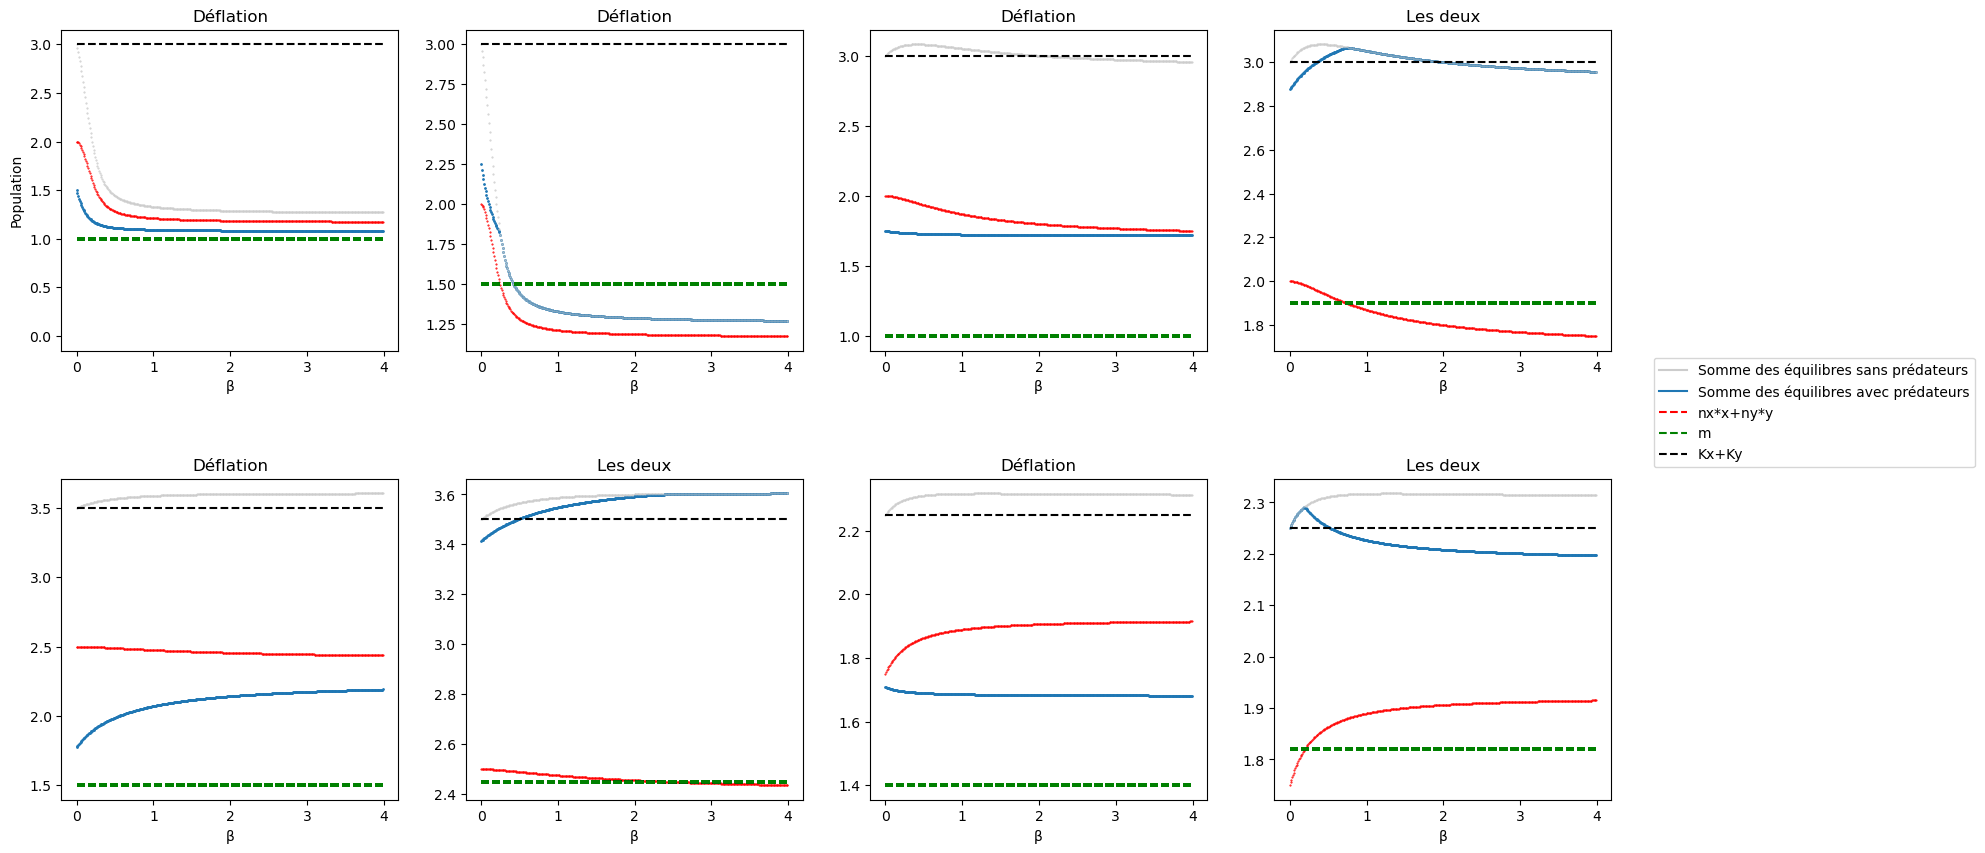

In [21]:
#Définition du modèle avec prédateurs:
def a(etat,t,param,i):
    x,y,z=etat
    b=i
    rx,Kx,ry,Ky,gx,gy,px,py,nx,ny,m = param
    xdot,ydot,zdot=[rx*x*(1-x/Kx)+b*(y/gy-x/gx)-px*z*x,ry*y*(1-y/Ky)+b*(x/gx-y/gy)-py*y*z,z*(nx*x+ny*y-m)]
    return [xdot,ydot,zdot]

#Définition du modèle sans prédateurs:
def aug2(etat,t,param,i):
    rx,Kx,ry,Ky,gx,gy=param
    b=i
    x,y=etat
    s=[rx*x*(1-x/Kx)+b*(y/gy-x/gx),ry*y*(1-y/Ky)+b*(x/gx-y/gy)]
    return s 

#Définition des paramètres:
#1:
rx1 = 0.5
ry1 = 1
Kx1 = 2
Ky1 = 1
gx1 = 0.5
gy1 = 3
px1=0.5
py1=1
nx1=0.5
ny1=1
m11=1
m12=1.5

param11p=np.array([rx1,Kx1,ry1,Ky1,gx1,gy1,px1,py1,nx1,ny1,m11])
param11sp=param11p[0:6]
param12p=np.array([rx1,Kx1,ry1,Ky1,gx1,gy1,px1,py1,nx1,ny1,m12])
param12sp=param12p[0:6]

#2:
rx2 = 0.5
ry2 = 1
Kx2 = 2
Ky2 = 1
gx2 = 5
gy2 = 1
px2=0.5
py2=3
nx2=0.5
ny2=1
m21=1
m22=1.9

param21p=np.array([rx2,Kx2,ry2,Ky2,gx2,gy2,px2,py2,nx2,ny2,m21])
param21sp=param21p[0:6]
param22p=np.array([rx2,Kx2,ry2,Ky2,gx2,gy2,px2,py2,nx2,ny2,m22])
param22sp=param22p[0:6]

#3:
rx3 = 1
ry3 = 2
Kx3 = 2
Ky3 = 1.5
gx3 = 2
gy3 = 1
px3=1
py3=0.5
nx3=0.5
ny3=1
m31=1.5
m32=2.45

param31p=np.array([rx3,Kx3,ry3,Ky3,gx3,gy3,px3,py3,nx3,ny3,m31])
param31sp=param31p[0:6]
param32p=np.array([rx3,Kx3,ry3,Ky3,gx3,gy3,px3,py3,nx3,ny3,m32])
param32sp=param32p[0:6]

#4:
rx4 = 2
ry4 = 1
Kx4 = 1
Ky4 = 1.25
gx4 = 0.5
gy4 = 1
px4=3
py4=0.5
nx4=0.5
ny4=1
m41=1.4
m42=1.82

param41p=np.array([rx4,Kx4,ry4,Ky4,gx4,gy4,px4,py4,nx4,ny4,m41])
param41sp=param41p[0:6]
param42p=np.array([rx4,Kx4,ry4,Ky4,gx4,gy4,px4,py4,nx4,ny4,m42])
param42sp=param42p[0:6]

#Temps d'intégration suffisament large pour atteindre l'équilibre:
t=np.arange(0,800,0.01)

#Condition initiale:
e0p=[1,1,1]
e0sp=[1,1]

#Figure:
fig,ax=plt.subplots(2,4,figsize=(20,10))
plt.subplots_adjust(hspace=0.4)

xt=np.arange(0,4,0.01)

#Boucle pour plot en fonction de beta:
for i in np.arange(0,4,0.01):
    s1p=odeint(a,e0p,t,args=(param11p,i)) #On calcule pour chaque beta l'équilibre
    s1sp=odeint(aug2,e0sp,t,args=(param11sp,i))
    ax[0][0].plot(i,s1p[-1][0]+s1p[-1][1],marker='.',markersize=2,color='C0') #On plot un point qui correspond à la valeur de la somme des éq. en fonction de beta
    ax[0][0].plot(i,nx1*s1sp[-1][0]+ny1*s1sp[-1][1],marker='.',markersize=1,color='r')
    ax[0][0].plot(xt,m11*np.ones_like(xt),linestyle="dashed",color='g')
    ax[0][0].plot(i,s1sp[-1][0]+s1sp[-1][1],marker='.',markersize=1,color='0.8')
    
    s1p=odeint(a,e0p,t,args=(param12p,i)) #On calcule pour chaque beta l'équilibre
    s1sp=odeint(aug2,e0sp,t,args=(param12sp,i))
    
    ax[0][1].plot(i,s1p[-1][0]+s1p[-1][1],marker='.',markersize=2,color='C0') #On plot un point qui correspond à la valeur de la somme des éq. en fonction de beta
    ax[0][1].plot(i,nx1*s1sp[-1][0]+ny1*s1sp[-1][1],marker='.',markersize=1,color='r')
    ax[0][1].plot(xt,m12*np.ones_like(xt),linestyle="dashed",color='g')
    ax[0][1].plot(i,s1sp[-1][0]+s1sp[-1][1],marker='.',markersize=1,color='0.8')
    
    
    s2p=odeint(a,e0p,t,args=(param21p,i)) #On calcule pour chaque beta l'équilibre
    s2sp=odeint(aug2,e0sp,t,args=(param21sp,i))
    
    ax[0][2].plot(i,s2p[-1][0]+s2p[-1][1],marker='.',markersize=2,color='C0') #On plot un point qui correspond à la valeur de la somme des éq. en fonction de beta
    ax[0][2].plot(i,nx2*s2sp[-1][0]+ny2*s2sp[-1][1],marker='.',markersize=1,color='r')
    ax[0][2].plot(xt,m21*np.ones_like(xt),linestyle="dashed",color='g')
    ax[0][2].plot(i,s2sp[-1][0]+s2sp[-1][1],marker='.',markersize=1,color='0.8')
    
    s2p=odeint(a,e0p,t,args=(param22p,i)) #On calcule pour chaque beta l'équilibre
    s2sp=odeint(aug2,e0sp,t,args=(param22sp,i))
    
    ax[0][3].plot(i,s2p[-1][0]+s2p[-1][1],marker='.',markersize=2,color='C0') #On plot un point qui correspond à la valeur de la somme des éq. en fonction de beta
    ax[0][3].plot(i,nx2*s2sp[-1][0]+ny2*s2sp[-1][1],marker='.',markersize=1,color='r')
    ax[0][3].plot(xt,m22*np.ones_like(xt),linestyle="dashed",color='g')
    ax[0][3].plot(i,s2sp[-1][0]+s2sp[-1][1],marker='.',markersize=1,color='0.8')
    
    
    s3p=odeint(a,e0p,t,args=(param31p,i)) #On calcule pour chaque beta l'équilibre
    s3sp=odeint(aug2,e0sp,t,args=(param31sp,i))
    
    ax[1][0].plot(i,s3p[-1][0]+s3p[-1][1],marker='.',markersize=2,color='C0') #On plot un point qui correspond à la valeur de la somme des éq. en fonction de beta
    ax[1][0].plot(i,nx3*s3sp[-1][0]+ny3*s3sp[-1][1],marker='.',markersize=1,color='r')
    ax[1][0].plot(xt,m31*np.ones_like(xt),linestyle="dashed",color='g')
    ax[1][0].plot(i,s3sp[-1][0]+s3sp[-1][1],marker='.',markersize=1,color='0.8')
    
    s3p=odeint(a,e0p,t,args=(param32p,i)) #On calcule pour chaque beta l'équilibre
    s3sp=odeint(aug2,e0sp,t,args=(param32sp,i))
    
    ax[1][1].plot(i,s3p[-1][0]+s3p[-1][1],marker='.',markersize=2,color='C0') #On plot un point qui correspond à la valeur de la somme des éq. en fonction de beta
    ax[1][1].plot(i,nx3*s3sp[-1][0]+ny3*s3sp[-1][1],marker='.',markersize=1,color='r')
    ax[1][1].plot(xt,m32*np.ones_like(xt),linestyle="dashed",color='g')
    ax[1][1].plot(i,s3sp[-1][0]+s3sp[-1][1],marker='.',markersize=1,color='0.8')
    
    
    s4p=odeint(a,e0p,t,args=(param41p,i)) #On calcule pour chaque beta l'équilibre
    s4sp=odeint(aug2,e0sp,t,args=(param41sp,i))
   
    ax[1][2].plot(i,s4p[-1][0]+s4p[-1][1],marker='.',markersize=2,color='C0') #On plot un point qui correspond à la valeur de la somme des éq. en fonction de beta
    ax[1][2].plot(i,nx4*s4sp[-1][0]+ny4*s4sp[-1][1],marker='.',markersize=1,color='r')
    ax[1][2].plot(xt,m41*np.ones_like(xt),linestyle="dashed",color='g')
    ax[1][2].plot(i,s4sp[-1][0]+s4sp[-1][1],marker='.',markersize=1,color='0.8')
    
    s4p=odeint(a,e0p,t,args=(param42p,i)) #On calcule pour chaque beta l'équilibre
    s4sp=odeint(aug2,e0sp,t,args=(param42sp,i))
    
    ax[1][3].plot(i,s4p[-1][0]+s4p[-1][1],marker='.',markersize=2,color='C0') #On plot un point qui correspond à la valeur de la somme des éq. en fonction de beta
    ax[1][3].plot(i,nx4*s4sp[-1][0]+ny4*s4sp[-1][1],marker='.',markersize=1,color='r')
    ax[1][3].plot(xt,m42*np.ones_like(xt),linestyle="dashed",color='g')
    ax[1][3].plot(i,s4sp[-1][0]+s4sp[-1][1],marker='.',markersize=1,color='0.8')
    
#Plot de la droite Kx+Ky:    
ax[0][0].plot(xt,(Kx1+Ky1)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[0][1].plot(xt,(Kx1+Ky1)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[0][2].plot(xt,(Kx2+Ky2)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[0][3].plot(xt,(Kx2+Ky2)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[1][0].plot(xt,(Kx3+Ky3)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[1][1].plot(xt,(Kx3+Ky3)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[1][2].plot(xt,(Kx4+Ky4)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[1][3].plot(xt,(Kx4+Ky4)*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')

#Légendes:
ax[0][0].set_xlabel('β')
ax[0][1].set_xlabel('β')
ax[0][2].set_xlabel('β')
ax[0][3].set_xlabel('β')
ax[1][0].set_xlabel('β')
ax[1][1].set_xlabel('β')
ax[1][2].set_xlabel('β')
ax[1][3].set_xlabel('β')

ax[0][0].set_ylabel('Population')
ax[0][0].plot(0,0,color='0.8',label='Somme des équilibres sans prédateurs')
ax[0][0].plot(0,0,color='C0',label='Somme des équilibres avec prédateurs')
ax[0][0].plot(0,0,linestyle='dashed',color='r',markersize='6',label='nx*x+ny*y')
ax[0][0].plot(0,0,linestyle='dashed',color='g',markersize='6',label='m')
ax[0][0].plot(0,0,linestyle='dashed',color='k',markersize='6',label='Kx+Ky')

#On déplace la légende hors de la figure:
ax[0][0].legend(bbox_to_anchor=(5.2, -0.5, 0.5, 0.5),fontsize=10)

#Titres:
ax[0][0].set_title('Déflation')
ax[0][1].set_title('Déflation')
ax[0][2].set_title('Déflation')
ax[0][3].set_title('Les deux')
ax[1][0].set_title('Déflation')
ax[1][1].set_title('Les deux')
ax[1][2].set_title('Déflation')
ax[1][3].set_title('Les deux')

On observe que si $m$ est toujours plus grand que $n_xx_1^*(\beta)+n_yy_1^*(\beta)$ alors les prédateurs disparaissent et on a que la somme des équilibres est égale à $x_1^*(\beta)+y_1^*(\beta)$.  
Ensuite, quand $m$ est toujours plus petit que $n_xx_1^*(\beta)+n_yy_1^*(\beta)$ alors les prédateurs sont toujours en vie et on a que la somme des équilibres est égale à $x_2^*(\beta)+y_2^*(\beta)$.  
Enfin, quand $m$ croise $x_1^*(\beta)+y_1^*(\beta)$ on observe que la somme des équilibres est à la fois $x_2^*(\beta)+y_2^*(\beta)$ et $x_1^*(\beta)+y_1^*(\beta)$. Si $n_xx_1^*(\beta)+n_yy_1^*(\beta)$ est croissant alors on a d'abord que la somme des équilibres est égale à $x_1^*(\beta)+y_1^*(\beta)$ puis $x_2^*(\beta)+y_2^*(\beta)$ et inversement si $n_xx_1^*(\beta)+n_yy_1^*(\beta)$ est décroissante.  

Lorsque les prédateurs sont toujours en vie on observe que le système est tout le temps déflationiste. Lorsque les prédateurs meurrent le système peut devenir inflationiste en suivant l'équilibre du 2).

#### **II) Equilibre des ravageurs dans la culture:**

On va maintenant tracer l'équilibre dans la culture en fonction du taux de migration et de fuite. 

Text(4.75, 0.9, '$K_x$')

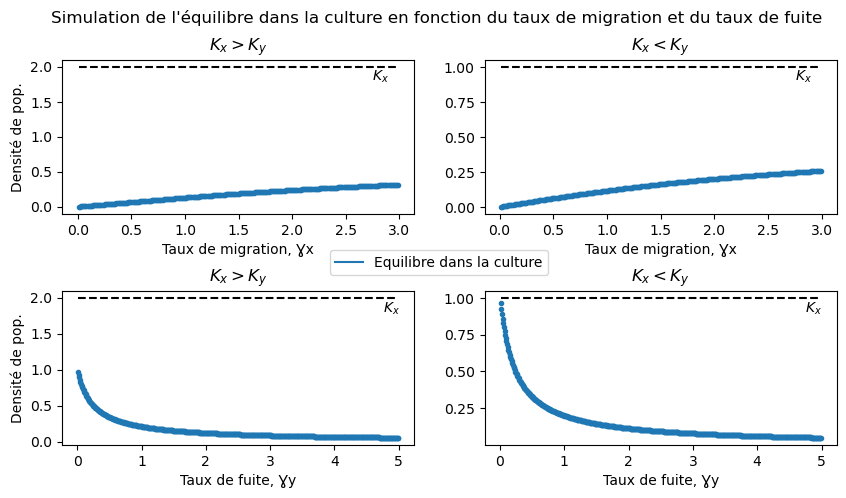

In [52]:
#On définit un modèle qui prend en compte le changement de b et un autre qui prend en compte le changement de gy
def a1(etat,t,param,i):
    x,y,z=etat
    gx=i
    rx,Kx,ry,Ky,b,gy,px,py,nx,ny,m = param
    xdot,ydot,zdot=[rx*x*(1-x/Kx)+b*(y/gy-x/gx)-px*z*x,ry*y*(1-y/Ky)+b*(x/gx-y/gy)-py*y*z,z*(nx*x+ny*y-m)]
    return [xdot,ydot,zdot]

def a2(etat,t,param,i):
    x,y,z=etat
    gy=i
    rx,Kx,ry,Ky,gx,b,px,py,nx,ny,m = param
    xdot,ydot,zdot=[rx*x*(1-x/Kx)+b*(y/gy-x/gx)-px*z*x,ry*y*(1-y/Ky)+b*(x/gx-y/gy)-py*y*z,z*(nx*x+ny*y-m)]
    return [xdot,ydot,zdot]

#Paramètres Simulation b1: 
rx1=0.5
ry1=1
Kx1=2
Ky1=1
b1=1
gy1=4
px1=0.5
py1=1
nx1=0.5
ny1=1
m1=0.5

param_a1=np.array([rx1,Kx1,ry1,Ky1,b1,gy1,px1,py1,nx1,ny1,m1])

#Paramètres Simulation b2: 
rx2=0.5
ry2=1
Kx2=1
Ky2=2
b2=1
gy2=4
px2=0.5
py2=1
nx2=0.5
ny2=1
m2=0.5

param_a2=np.array([rx2,Kx2,ry2,Ky2,b2,gy2,px2,py2,nx2,ny2,m2])

#Paramètres Simulation gy1: 
rx3=0.5
ry3=1
Kx3=2
Ky3=1
gx3=0.5
b3=1
px3=0.5
py3=1
nx3=0.5
ny3=1
m3=0.5

param_a3=np.array([rx3,Kx3,ry3,Ky3,gx3,b3,px3,py3,nx3,ny3,m3])

#Paramètres Simulation gy2: 
rx4=0.5
ry4=1
Kx4=1
Ky4=2
gx4=0.5
b4=1
px4=0.5
py4=1
nx4=0.5
ny4=1
m4=0.5

param_a4=np.array([rx4,Kx4,ry4,Ky4,gx4,b4,px4,py4,nx4,ny4,m4])

#Temps d'intégration:
t1=np.arange(0,500,0.01)

#Conditions initiales:
x0=1
y0=1
z0=1
c0=np.array([x0,y0,z0])

#On trace la figure:
fig1,ax=plt.subplots(2,2,figsize=(10,5))

#Boucle qui met à jour b et simule à chaque fois l'équilibre :
for i in np.arange(0.01,3,0.01):
    sa1=odeint(a1,c0,t1,args=(param_a1,i))
    ax[0][0].plot(i,sa1[-1][0],marker='.',color='C0')
    sa2=odeint(a1,c0,t1,args=(param_a2,i))
    ax[0][1].plot(i,sa2[-1][0],marker='.',color='C0')

#Boucle qui met à jour gy et simule l'équilibre:
for i in np.arange(0.01,5,0.01):
    sa3=odeint(a2,c0,t1,args=(param_a3,i))
    ax[1][0].plot(i,sa3[-1][0],marker='.',color='C0')
    sa4=odeint(a2,c0,t1,args=(param_a4,i))
    ax[1][1].plot(i,sa4[-1][0],marker='.',color='C0')

#On plot la ligne correspondant à Kx
xt=np.arange(0.01,3,0.01)
xt2=np.arange(0.01,5,0.01)
ax[0][0].plot(xt,Kx1*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[0][1].plot(xt,Kx2*np.ones_like(xt),linestyle='dashed',color='k',markersize='6')
ax[1][0].plot(xt2,Kx3*np.ones_like(xt2),linestyle='dashed',color='k',markersize='6')
ax[1][1].plot(xt2,Kx4*np.ones_like(xt2),linestyle='dashed',color='k',markersize='6')

##Légendes et titres:
fig1.suptitle("Simulation de l\'équilibre dans la culture en fonction du taux de migration et du taux de fuite")

#Abssices:
ax[0][0].set_xlabel("Taux de migration, Ɣx")
ax[0][1].set_xlabel("Taux de migration, Ɣx")
ax[1][0].set_xlabel("Taux de fuite, Ɣy")
ax[1][1].set_xlabel("Taux de fuite, Ɣy")

#Titre des sous figures:
ax[0][0].set_title("$K_x>K_y$")
ax[0][1].set_title("$K_x<K_y$")
ax[1][0].set_title("$K_x>K_y$")
ax[1][1].set_title("$K_x<K_y$")

#Ordonnées:
ax[0][0].set_ylabel("Densité de pop.")
ax[1][0].set_ylabel("Densité de pop.")

#Légende générale:
ax[0][0].plot(0,0,color='C0',label='Equilibre dans la culture')

#On déplace la légende hors de la figure:
ax[0][0].legend(bbox_to_anchor=(0.9, -0.69, 0.5, 0.5))

#Ecartement des figures:
plt.subplots_adjust(hspace=0.5)

#Texte Kx:
ax[0][0].text(2.75,Kx1-0.2,'$K_x$')
ax[0][1].text(2.75,Kx2-0.1,'$K_x$')
ax[1][0].text(4.75,Kx3-0.2,'$K_x$')
ax[1][1].text(4.75,Kx4-0.1,'$K_x$')

Les résultats sont similaires au modèle simplifié : 

En haut on observe l'équilibre en fonction du **taux de migration**. On voit que quelque soit la culture on a un équilibre qui est bien en dessous de la capactié biotique de la culture. La technique de l'augmentorium semble être efficace.  
On observe que quand le taux de migration est fort ($\gamma_x$ petit) alors on a un équilibre dans la culture faible et celui augmente au fur et à mesure que le taux de migration ralentit. Mettre de l'effort dans la tache de ramasser les fruits et les séquestrer n'est donc pas vain.  

Maintenant quand on regarde le **taux de fuite**, s'il est élevé (valeur petite de $\gamma_y$) alors on a un équilibre dans la culture plus grand que si il est faible. Plus $\gamma_y$ est grand (et donc plus le taux de fuite est faible) moins l'équilibre dans la culture est élevé.  
Ce paramètre est donc crucial et c'est quelque chose qu'il faut continuer d'améliorer (en mettant en place des sas, de la lumière à l'opposé de l'entrée pour attirer les ravageurs etc.). 

### F) Applications à l'augmentorium:

Quand on applique les hypothèses de l'augmentorium décrite en A) on a premièrement que on obtient seulement trois profils de courbes (on a pas celle en bas à droite sur les graphes).  
De plus avec des paramètres ressemblant à l'augmentorium le système est constamment déflationiste car le système 2) est lui même déflationiste.  